# EdgeFactory : testing computation of edge co-occurences

In [1]:
import matplotlib
#matplotlib.rcParams.update({'font.size': 18, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})
matplotlib.rcParams.update({'text.usetex': False})
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt

import numpy as np
np.set_printoptions(precision=4)#, suppress=True)
# http://ipython.org/ipython-doc/stable/config/extensions/autoreload.html
#%load_ext autoreload
#%autoreload 2

# where should we store the figures generated by this notebook
figpath = ''
figpath = '../../CNRS/BICV-book/BICV_INT/BICV-sparse/'

In [2]:
#! defining framework
#!-------------------
from SparseEdges import SparseEdges
mp = SparseEdges('https://raw.githubusercontent.com/meduz/SparseEdges/master/default_param.py')
mp.pe.N = 4
mp.pe.do_mask = False
mp.pe.MP_alpha = 1.
mp.pe.do_whitening = False
mp.init()

print 'Range of spatial frequencies: ', mp.sf_0

Range of spatial frequencies:  [ 0.618   0.382   0.2361  0.1459  0.0902  0.0557  0.0344  0.0213  0.0132
  0.0081  0.005 ]


In [3]:
#! this test report is about the MatchingPursuit class:
print SparseEdges.__doc__

None


In [4]:
print 'Range of angles: ', mp.theta*180./np.pi

Range of angles:  [-82.5 -75.  -67.5 -60.  -52.5 -45.  -37.5 -30.  -22.5 -15.   -7.5   0.
   7.5  15.   22.5  30.   37.5  45.   52.5  60.   67.5  75.   82.5  90. ]


NOTE: everything below this point should go to another notebook

## Computing edge statistics 

In [5]:
from SparseEdges import SparseEdges

In [6]:
mp = SparseEdges('default_param.py')
mp.pe.figsize_edges = 12
print mp.pe

{'edge_mask': True, 'figsize_cohist': 3.41, 'N_Y': 256, 'loglevel_max': 7, 'B_theta': 0.17453277777777776, 'do_mask': True, 'd_max': 2.0, 'n_theta': 24, 'dip_B_theta': 1.0, 'figsize_edges': 12, 'N_scale': 5, 'seed': None, 'base_levels': 1.618, 'line_width_chevrons': 0.75, 'scale_circle': 0.08, 'N_X': 256, 'do_rank': False, 'verbose': 30, 'scale': 0.8, 'noise': 0.33, 'N_image': 100, 'datapath': '../AssoField/database/', 'N_r': 6, 'white_N': 0.07, 'edgematpath': 'mat/edges/', 'white_recompute': False, 'd_min': 0.25, 'MP_do_mask': True, 'white_n_learning': 0, 'MP_alpha': 0.7, 'edge_scale_chevrons': 180.0, 'B_sf': 0.4, 'white_alpha': 1.4, 'white_name_database': 'serre07_distractors', 'N_phi': 12, 'N_Dtheta': 24, 'white_N_0': 0.0, 'do_whitening': True, 'matpath': 'mat/', 'N': 2048, 'scale_invariant': True, 'kappa_phase': 0.0, 'dip_w': 0.2, 'd_width': 45.0, 'MP_rho': None, 'multiscale': True, 'weight_by_distance': True, 'line_width': 1.0, 'dip_epsilon': 0.5, 'white_f_0': 0.4, 'scale_chevrons

In [7]:
mp.pe.n_levels = np.log2(mp.N_X)

### Basics

#### setting up coordinates conventions

cardinal points in X, Y (clockwise):  E (=right=3 o'clock=horizontal), ESE, S, WSW, W, WNW, N, ENE 

In [8]:
X = np.array([0, 1./4, 1./2, 1./4, 0, -1./4, -1./2])#, -1./4])\n",
Y = np.array([1./2, np.sqrt(3)/4, 0, -np.sqrt(3)/4, -1./2, -np.sqrt(3)/4, 0.])#, np.sqrt(3)/
Theta = np.arctan2(-X, Y)
Theta = ((Theta + np.pi/2  - np.pi/mp.pe.N_phi/2 ) % (np.pi)) - np.pi/2  + np.pi/mp.pe.N_phi/2
print Theta* 180./np.pi

[ -4.7708e-15  -3.0000e+01   9.0000e+01   3.0000e+01  -4.7708e-15
  -3.0000e+01   9.0000e+01]


The X, Y image axis are defined in the matrix style (origin on the upper left; X going vertically down, Y going right horizontally) - the angle is defined as the angle wrt to the horizontal axis :

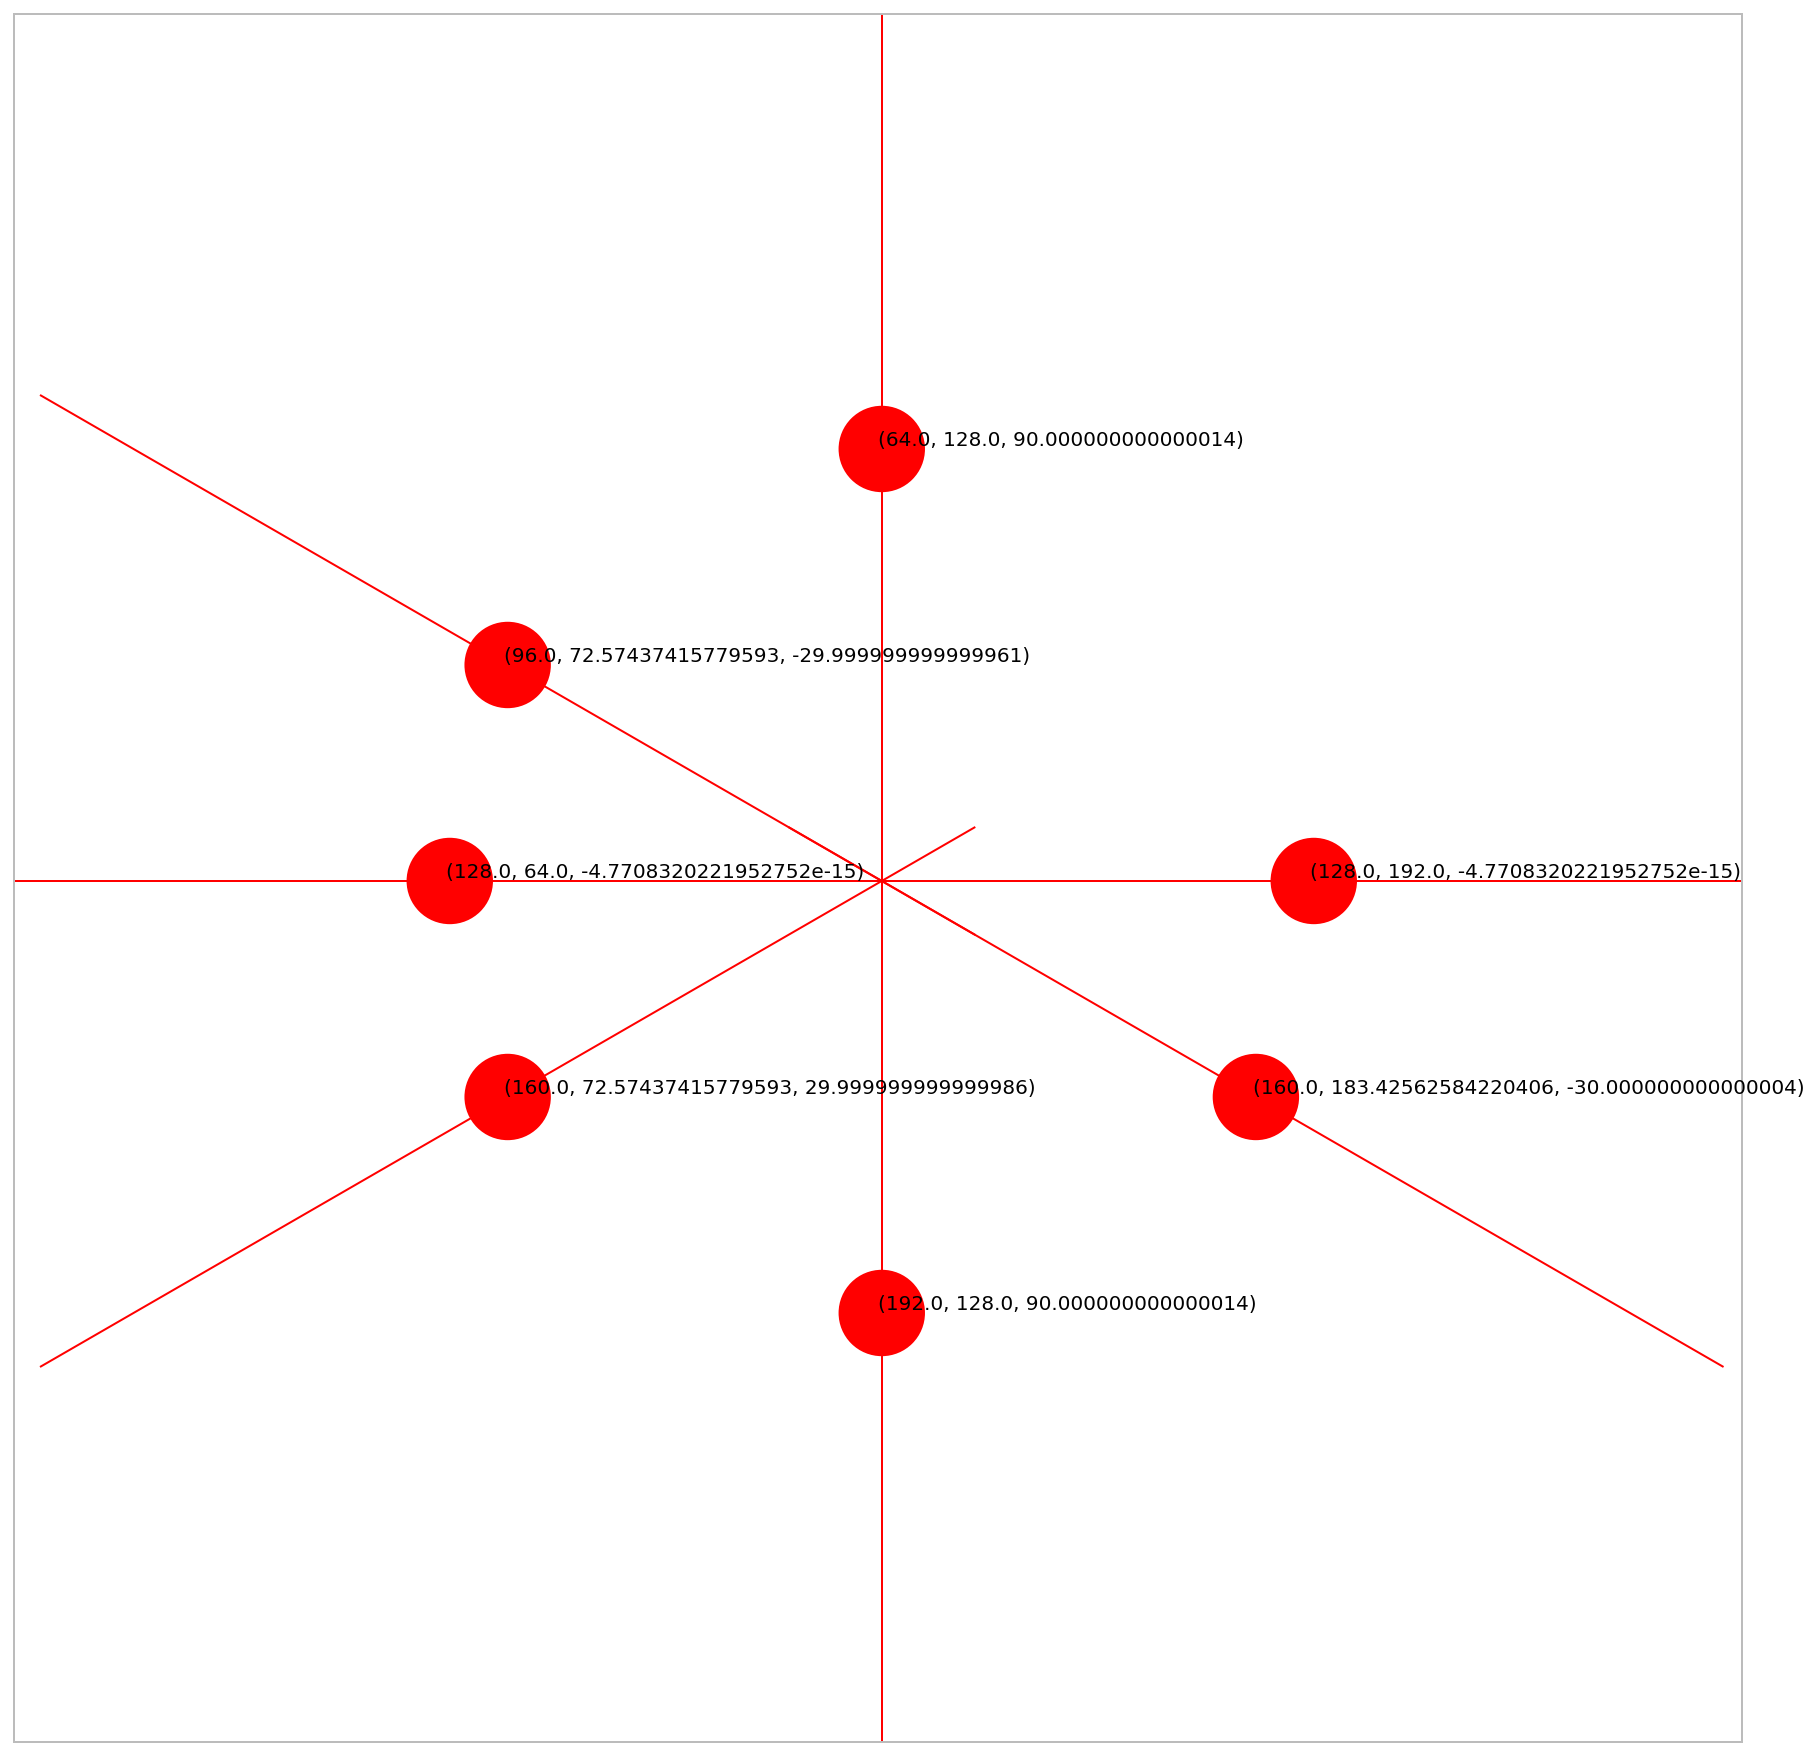

In [9]:
fig, a = mp.show_edges(np.vstack(((X/2. + .5)*mp.N_X, (Y/2. + .5)*mp.N_X, Theta, .01*np.ones(X.shape), np.ones(X.shape), np.zeros(X.shape) )))
t = [a.text(Y_, X_, np.str((X_, Y_, angle*180/np.pi))) for (X_, Y_, angle)  in zip((X/2. + .5)*mp.N_X, (Y/2. + .5)*mp.N_X, Theta)]

#### Testing some angle calculations

coord =  [  64.   64.  192.] [  64.  192.   64.]
angle (CCW wrt horizontal) = [  0.  45.  90.]


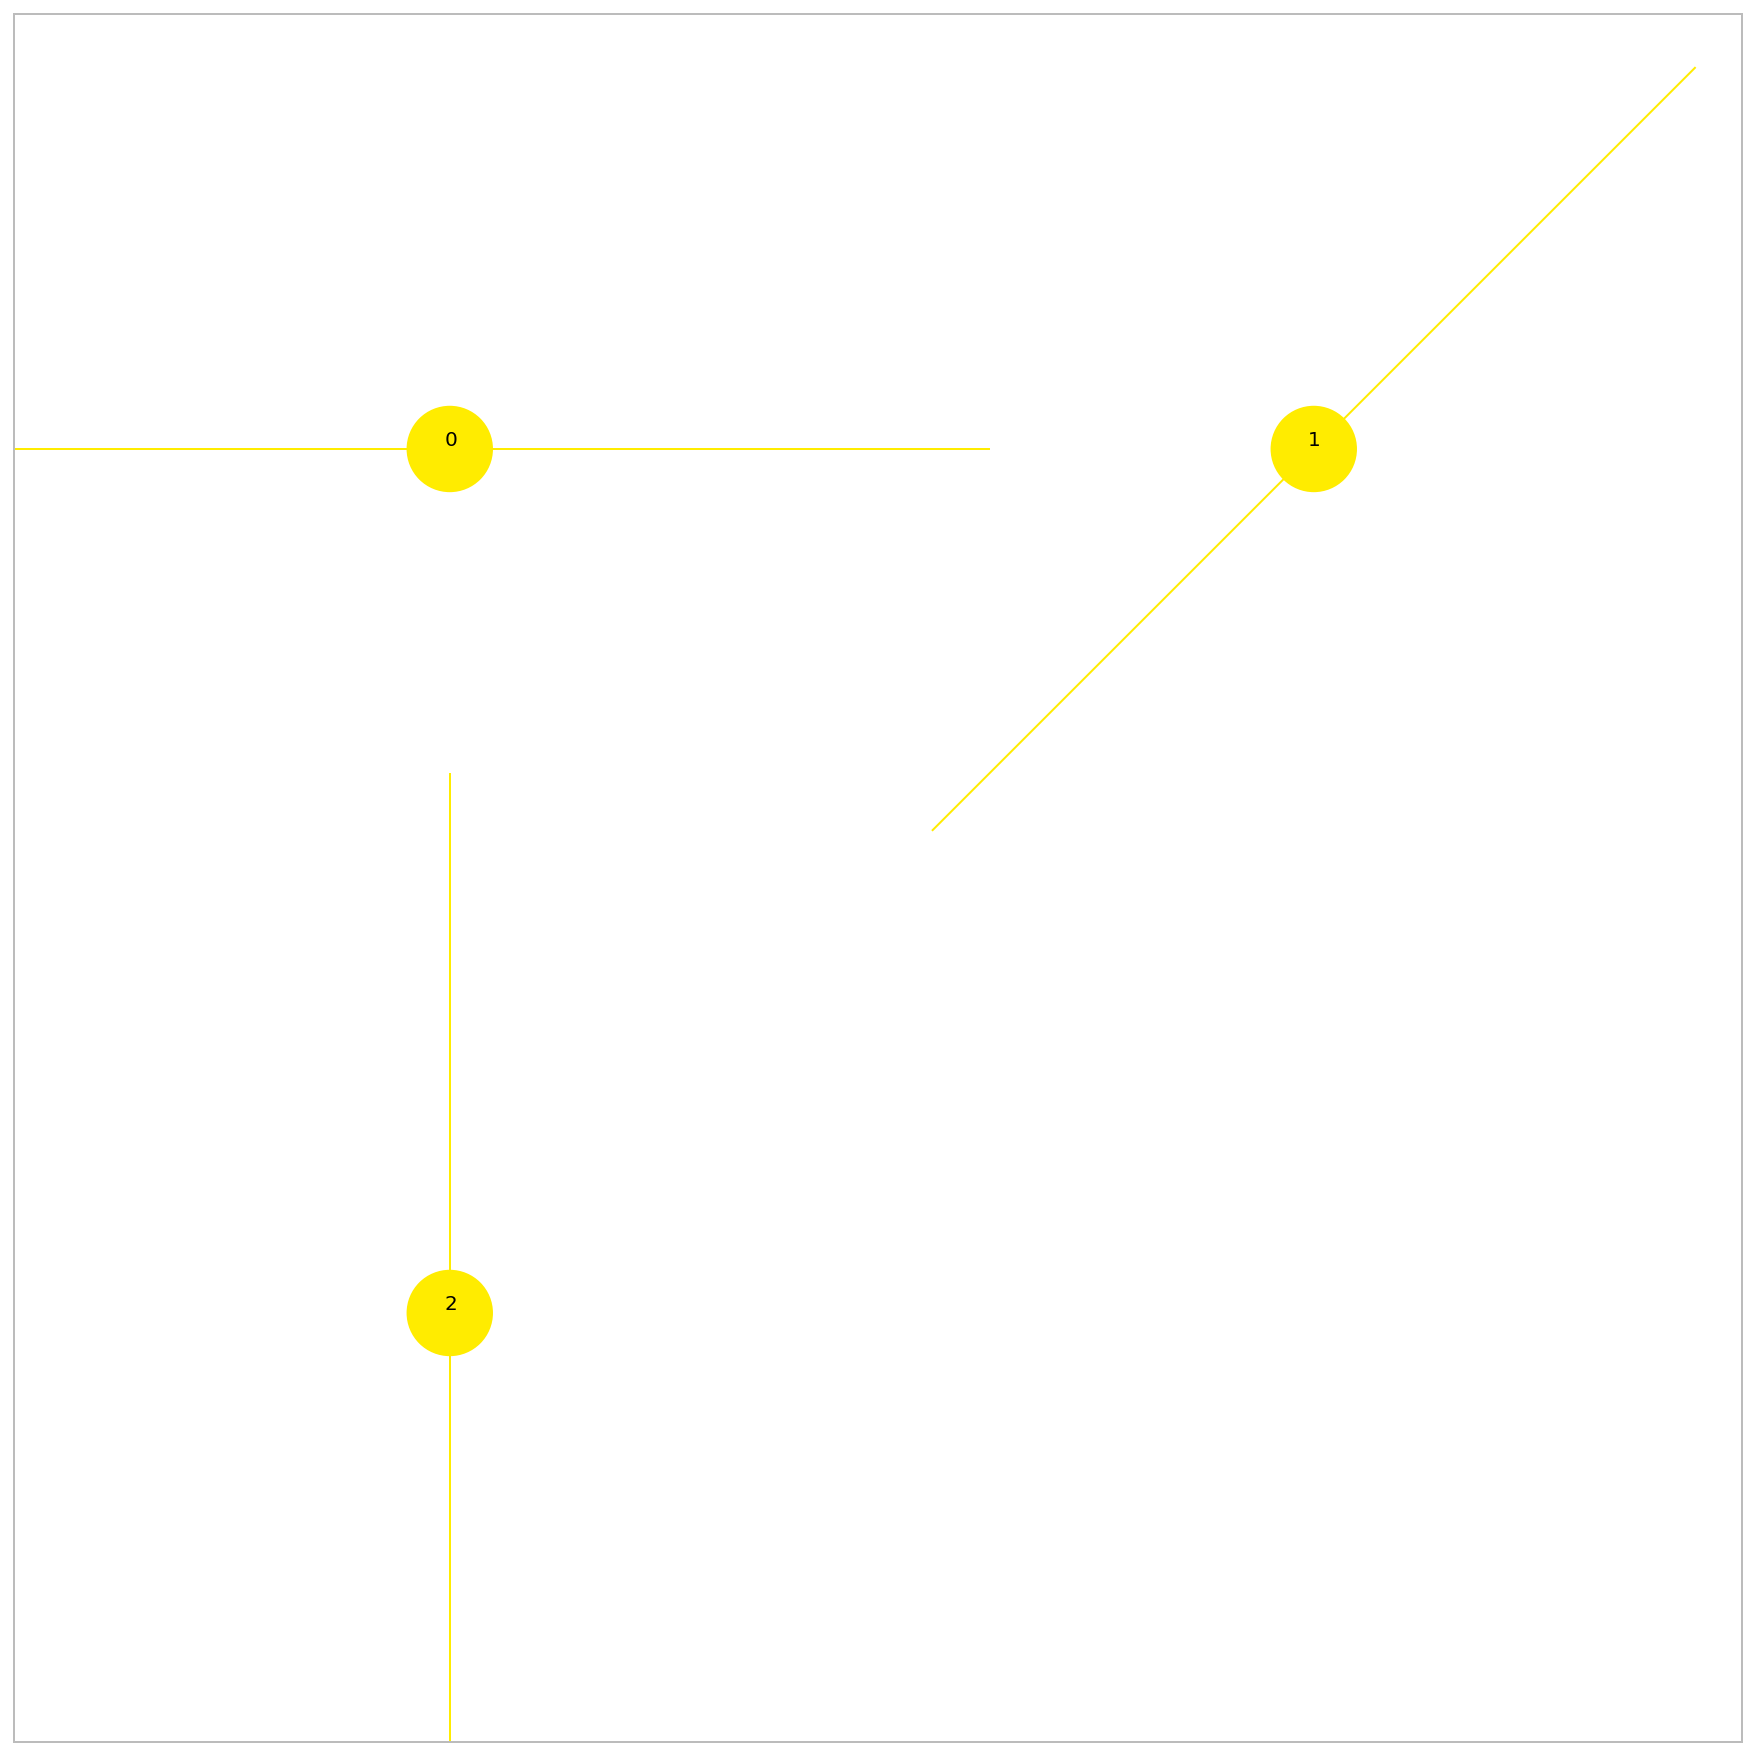

In [10]:
# test points
X = np.array([0.25, 0.25, 0.75])
Y = np.array([0.25, 0.75, 0.25])
X, Y = X*mp.N_X, Y*mp.N_X
print 'coord = ', X, Y
# by definition, theta = 0 is the horizontal
Theta = np.array([0., np.pi/4, np.pi/2])
print 'angle (CCW wrt horizontal) =', Theta * 180./np.pi
Sf_0, Weights, Phases = .01*np.ones(X.shape), np.ones(X.shape), np.ones(X.shape)
fig, a = mp.show_edges(np.vstack((X, Y, Theta, Sf_0, Weights, Phases)))
#t = [a.text(Y_, X_, np.str((X_, Y_, '%0.3f ' % (angle*180/np.pi), i))) for (X_, Y_, angle, i)  in zip((X/2. + .5)*N_X, (Y/2. + .5)*N_Y, Theta, range(3))]
t = [a.text(Y_, X_, np.str(i)) for (X_, Y_, i)  in zip(X, Y, range(3))]

#### Relative distance

In [11]:
dx = X[:, np.newaxis] - X[np.newaxis, :]
dy = Y[:, np.newaxis] - Y[np.newaxis, :]
print 'dx_ij = \n', dx, '\n dy_ij = \n', dy

dx_ij = 
[[   0.    0. -128.]
 [   0.    0. -128.]
 [ 128.  128.    0.]] 
 dy_ij = 
[[   0. -128.    0.]
 [ 128.    0.  128.]
 [   0. -128.    0.]]


[ 0.  0.  0.] [   0.  128.  128.]


<matplotlib.colorbar.Colorbar instance at 0x1067f0488>

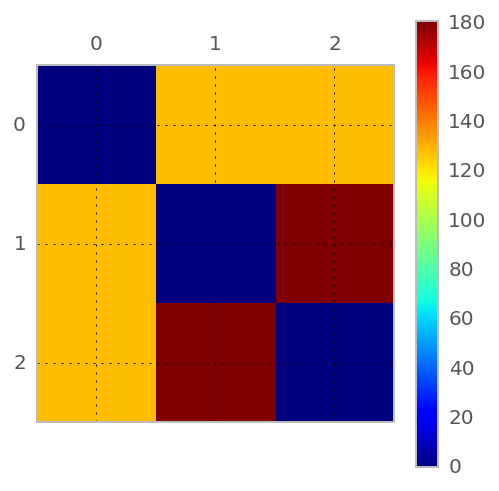

In [12]:
d = np.sqrt(dx**2 + dy**2) #/ pe.N_X * pe.d_width # distance in visual angle
print np.diag(d), d[0, :]
plt.matshow(d); plt.colorbar()

angle to self =  [ 0.  0.  0.] 
angle from 2 to ...=  [ 90.  45.   0.]
[[  0. -45. -90.]
 [ 45.   0. -45.]
 [ 90.  45.   0.]]


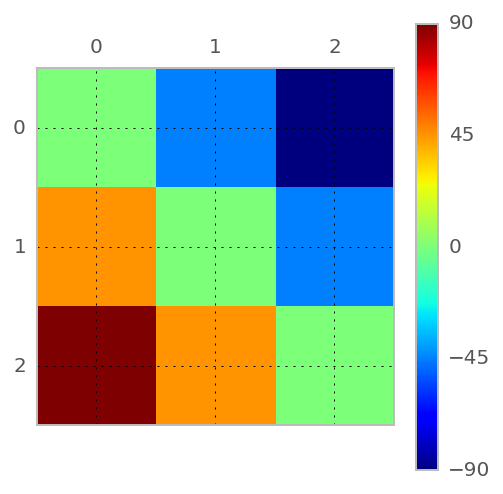

In [13]:
theta = Theta[:, np.newaxis] - Theta[np.newaxis, :]
print 'angle to self = ', np.diag(theta), '\nangle from 2 to ...= ', theta[2, :]*180/np.pi
plt.matshow(theta*180/np.pi); plt.colorbar(ticks=np.linspace(-90, 90, 5))
print theta*180/np.pi

0.0 -45.0 90.0
[[  3.9757e-15  -4.5000e+01   9.0000e+01]
 [  4.5000e+01   3.9757e-15  -4.5000e+01]
 [  9.0000e+01   4.5000e+01   3.9757e-15]]


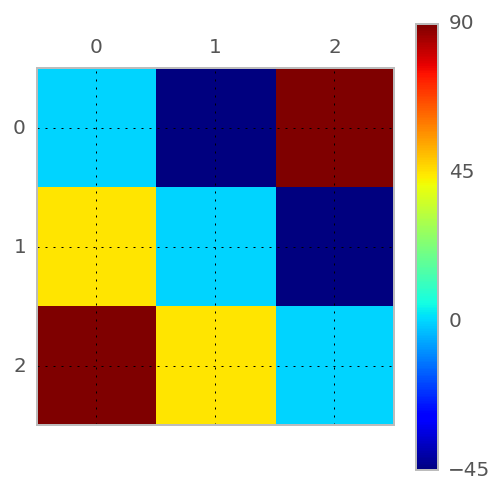

In [14]:
theta = ((theta + np.pi/2 - np.pi/mp.pe.N_Dtheta/2)  % (np.pi) ) - np.pi/2  + np.pi/mp.pe.N_Dtheta/2
plt.matshow(theta*180/np.pi); plt.colorbar(ticks=np.linspace(-90, 90, 5))
print np.diag(theta).std(), theta.min()*180/np.pi, theta.max()*180/np.pi
print theta*180/np.pi

<matplotlib.colorbar.Colorbar instance at 0x108ed45a8>

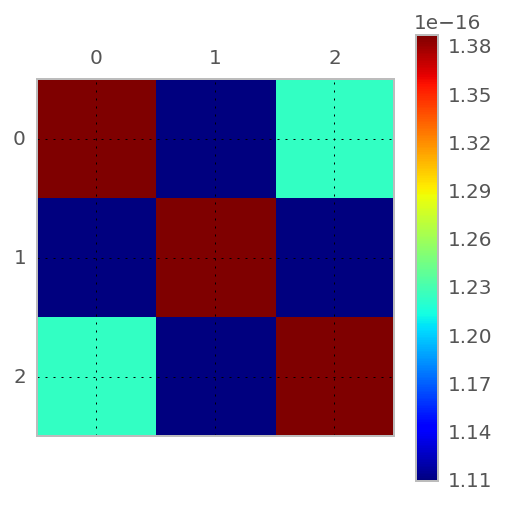

In [15]:
# still anti-symmetric (theta == - theta.T)
plt.matshow(np.sin(theta + theta.T)); plt.colorbar()

phi is the azimuth of the other edge wrt a reference, the matrix gives phi_ij = phi of j wrt i

[[ -90. -180.   90.]
 [   0.  -90.   45.]
 [ -90. -135.  -90.]] [  0.  45.  90.]
[[  nan  135.    0.]
 [   0.   nan  -45.]
 [ -90. -180.   nan]]


<matplotlib.colorbar.Colorbar instance at 0x10bdd47a0>

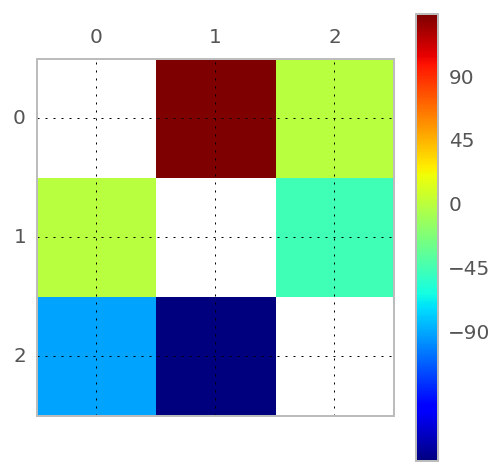

In [16]:
print (np.arctan2(dy, dx) - np.pi/2)*180/np.pi, Theta*180/np.pi
#np.seterr(all='ignore')
phi = (np.arctan2(dy, dx) - np.pi/2 - Theta[np.newaxis, :] + np.pi ) % (2*np.pi)  - np.pi
phi += np.diag(np.nan*np.ones(3))
#print np.isnan(phi)
#phi[np.isnan(phi)] = 0.
print phi*180/np.pi# np.diag(phi, 1)*180/np.pi, phi[0, :]*180/np.pi
plt.matshow(phi*180/np.pi); plt.colorbar(ticks=np.linspace(-90, 90, 5))

<matplotlib.colorbar.Colorbar instance at 0x10bd8d5f0>

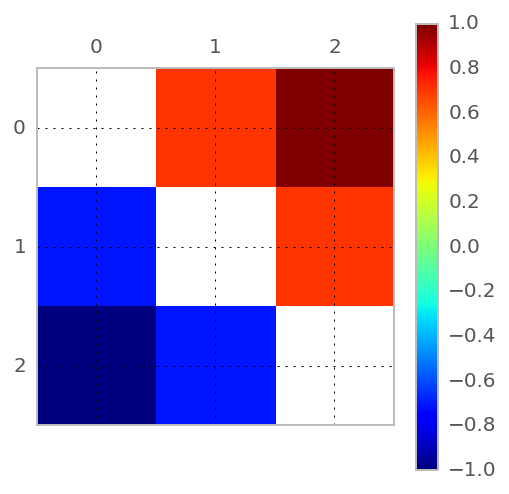

In [17]:
# not symmetric
plt.matshow(np.sin(phi - phi.T)); plt.colorbar()

[[   nan -202.5   45. ]
 [ -22.5    nan  -22.5]
 [-135.  -202.5    nan]]


<matplotlib.colorbar.Colorbar instance at 0x10bd00a28>

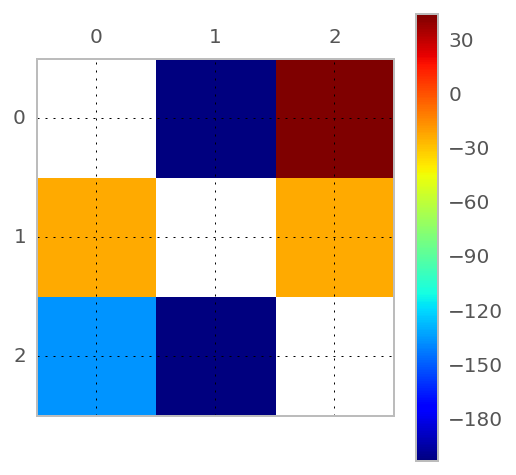

In [18]:
theta = Theta[:, np.newaxis] - Theta[np.newaxis, :]
phi = np.arctan2(dy, dx) - np.pi/2 - Theta[np.newaxis, :]
phi += np.diag(np.nan*np.ones(3))
psi = phi - theta/2
#psi = (Theta[:, np.newaxis]+Theta[np.newaxis, :])/2 + np.arctan2(-dx, dy)# + np.pi/2
print psi*180/np.pi#, (psi - (psi + psi.T)/2)*180/np.pi
plt.matshow(psi*180/np.pi); plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x10bb44320>

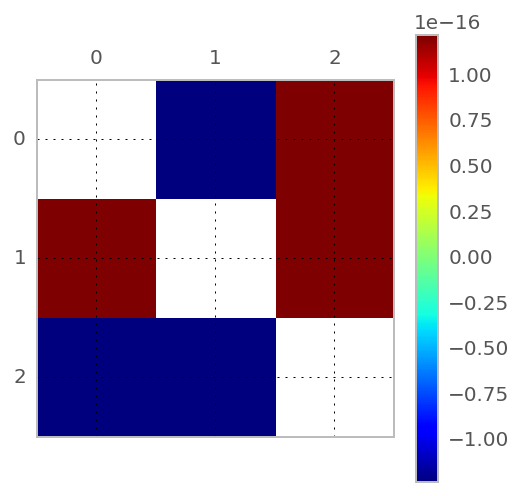

In [19]:
# symmetric
plt.matshow(np.sin(psi - psi.T)); plt.colorbar()

if we assume that an angle occurrence may also happen wrt to its mirror symetric (flipping left and right), then $\psi$ becomes non-oriented

[[  nan -22.5  45. ]
 [-22.5   nan -22.5]
 [ 45.  -22.5   nan]]


<matplotlib.colorbar.Colorbar instance at 0x10c370b00>

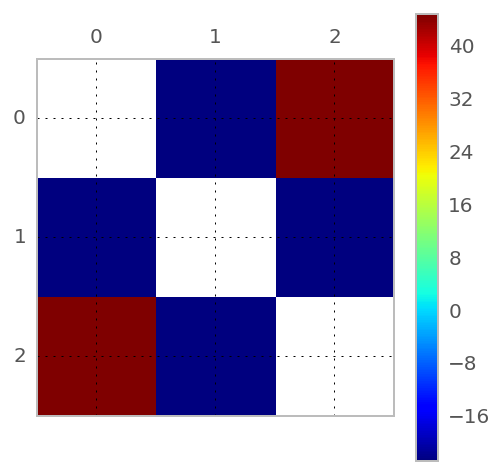

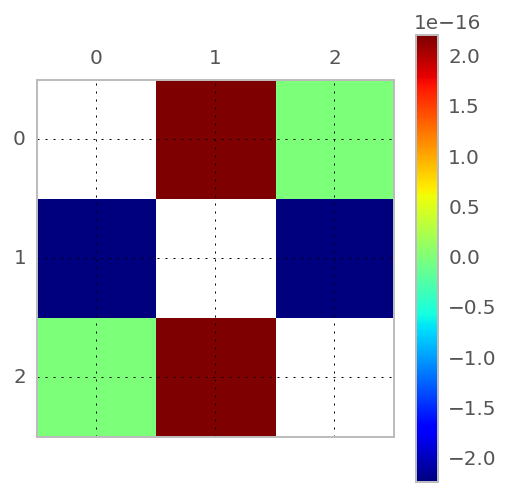

In [20]:
# putting everything in the right range:
psi = ((psi + np.pi/2  - np.pi/mp.pe.N_phi/2 ) % (np.pi)) - np.pi/2  + np.pi/mp.pe.N_phi/2
print psi*180/np.pi
plt.matshow(psi*180/np.pi); plt.colorbar()
#  still symmetric
plt.matshow(psi - psi.T); plt.colorbar()
#print np.sin(psi - psi.T).std()

<matplotlib.colorbar.Colorbar instance at 0x10c6ffc20>

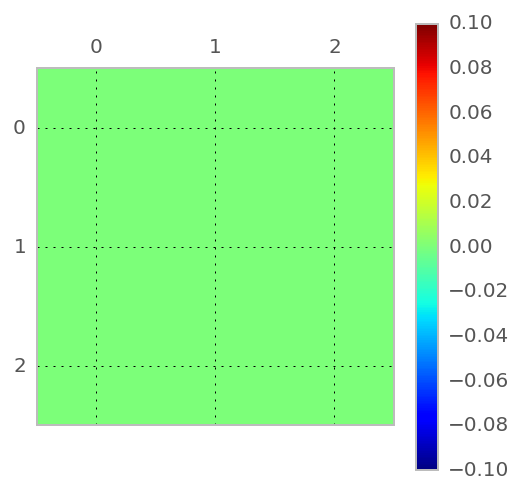

In [21]:
level = np.log2(Sf_0[:, np.newaxis]) - np.log2(Sf_0[np.newaxis, :])
plt.matshow(level); plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x10cadfcf8>

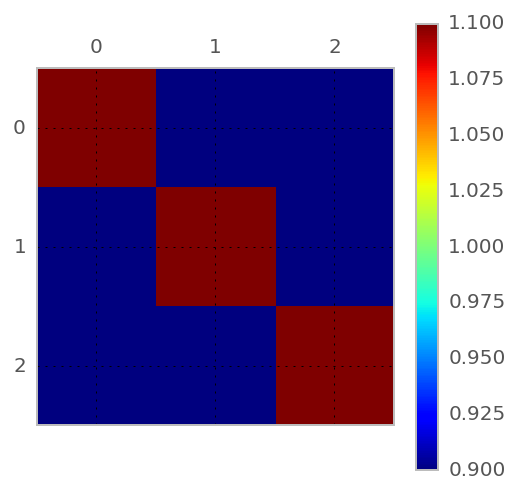

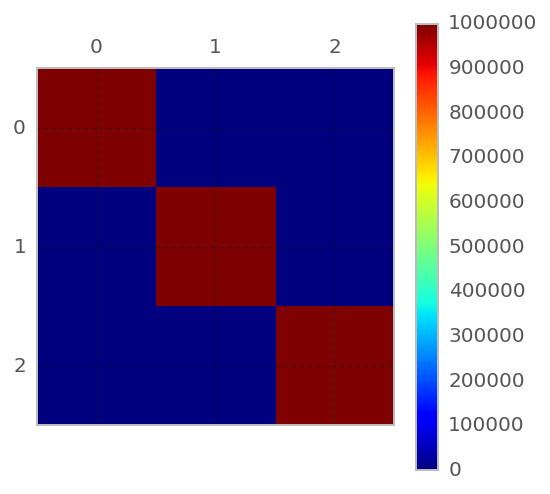

In [22]:
weights = Weights[:, np.newaxis] * Weights[np.newaxis, :]
plt.matshow(weights); plt.colorbar()
weights /= (d + 1.e-6)
plt.matshow(weights); plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x10cf54fc8>

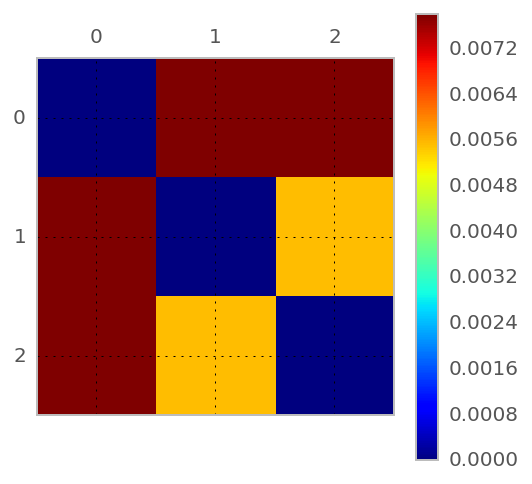

In [23]:
weights[d==0.] = 0. # exclude self-occurence
plt.matshow(weights); plt.colorbar()

### testing the plotting functions using synthetic edge images

In [24]:
print SparseEdges.histedges_theta.__doc__
print SparseEdges.histedges_scale.__doc__
print SparseEdges.cohistedges.__doc__


        First-order stats

        p(theta | I )

        

        First-order stats for the scale

        p(scale | I )

        

        second-order stats= center all edges around the current one by rotating and scaling

        p(x-x_, y-y_, theta-theta_ | I, x_, y_, theta_)

        


In [25]:
#! a function to display edges
def myplot(edgeslist, mp):

    fig = plt.figure(figsize=(12, 18))
    a1 = fig.add_subplot(321)
    fig, a = mp.show_edges(edgeslist[:, :, 0], image=np.ones((mp.N_X, mp.N_X)), fig=fig, a=a1)
    a2 = fig.add_subplot(322)
    fig, a2 = mp.histedges_scale(edgeslist, fig=fig, a=a2)
    a3 = fig.add_subplot(323, polar=True)
    fig, a3 = mp.histedges_theta(edgeslist, fig=fig, a=a3)
    a4 = fig.add_subplot(324)
    v_hist = mp.cohistedges(edgeslist, display='none')
    v_hist_nosym = mp.cohistedges(edgeslist, display='none', symmetry=False)
    fig, a4 = mp.cohistedges(edgeslist=None, v_hist=v_hist, fig=fig, a=a4)
    a5 = fig.add_subplot(325)
    fig, a5 = mp.cohistedges(edgeslist=None, v_hist=v_hist_nosym, fig=fig, a=a5, symmetry=False, display='colin_geisler')
    a6 = fig.add_subplot(326)
    fig, a6 = mp.cohistedges(edgeslist=None, v_hist=v_hist_nosym, fig=fig, a=a6, symmetry=False, display='cocir_geisler')
    #plt.tight_layout()
    plt.show()
    fig2 = plt.figure(figsize=(12, 12))
    fig2, a1, a2, a3, a4 = mp.cohistedges(edgeslist=None, v_hist=v_hist, fig=fig2, display='full')
    return v_hist

#### Just with 2 edges and  averaged over N_images trials

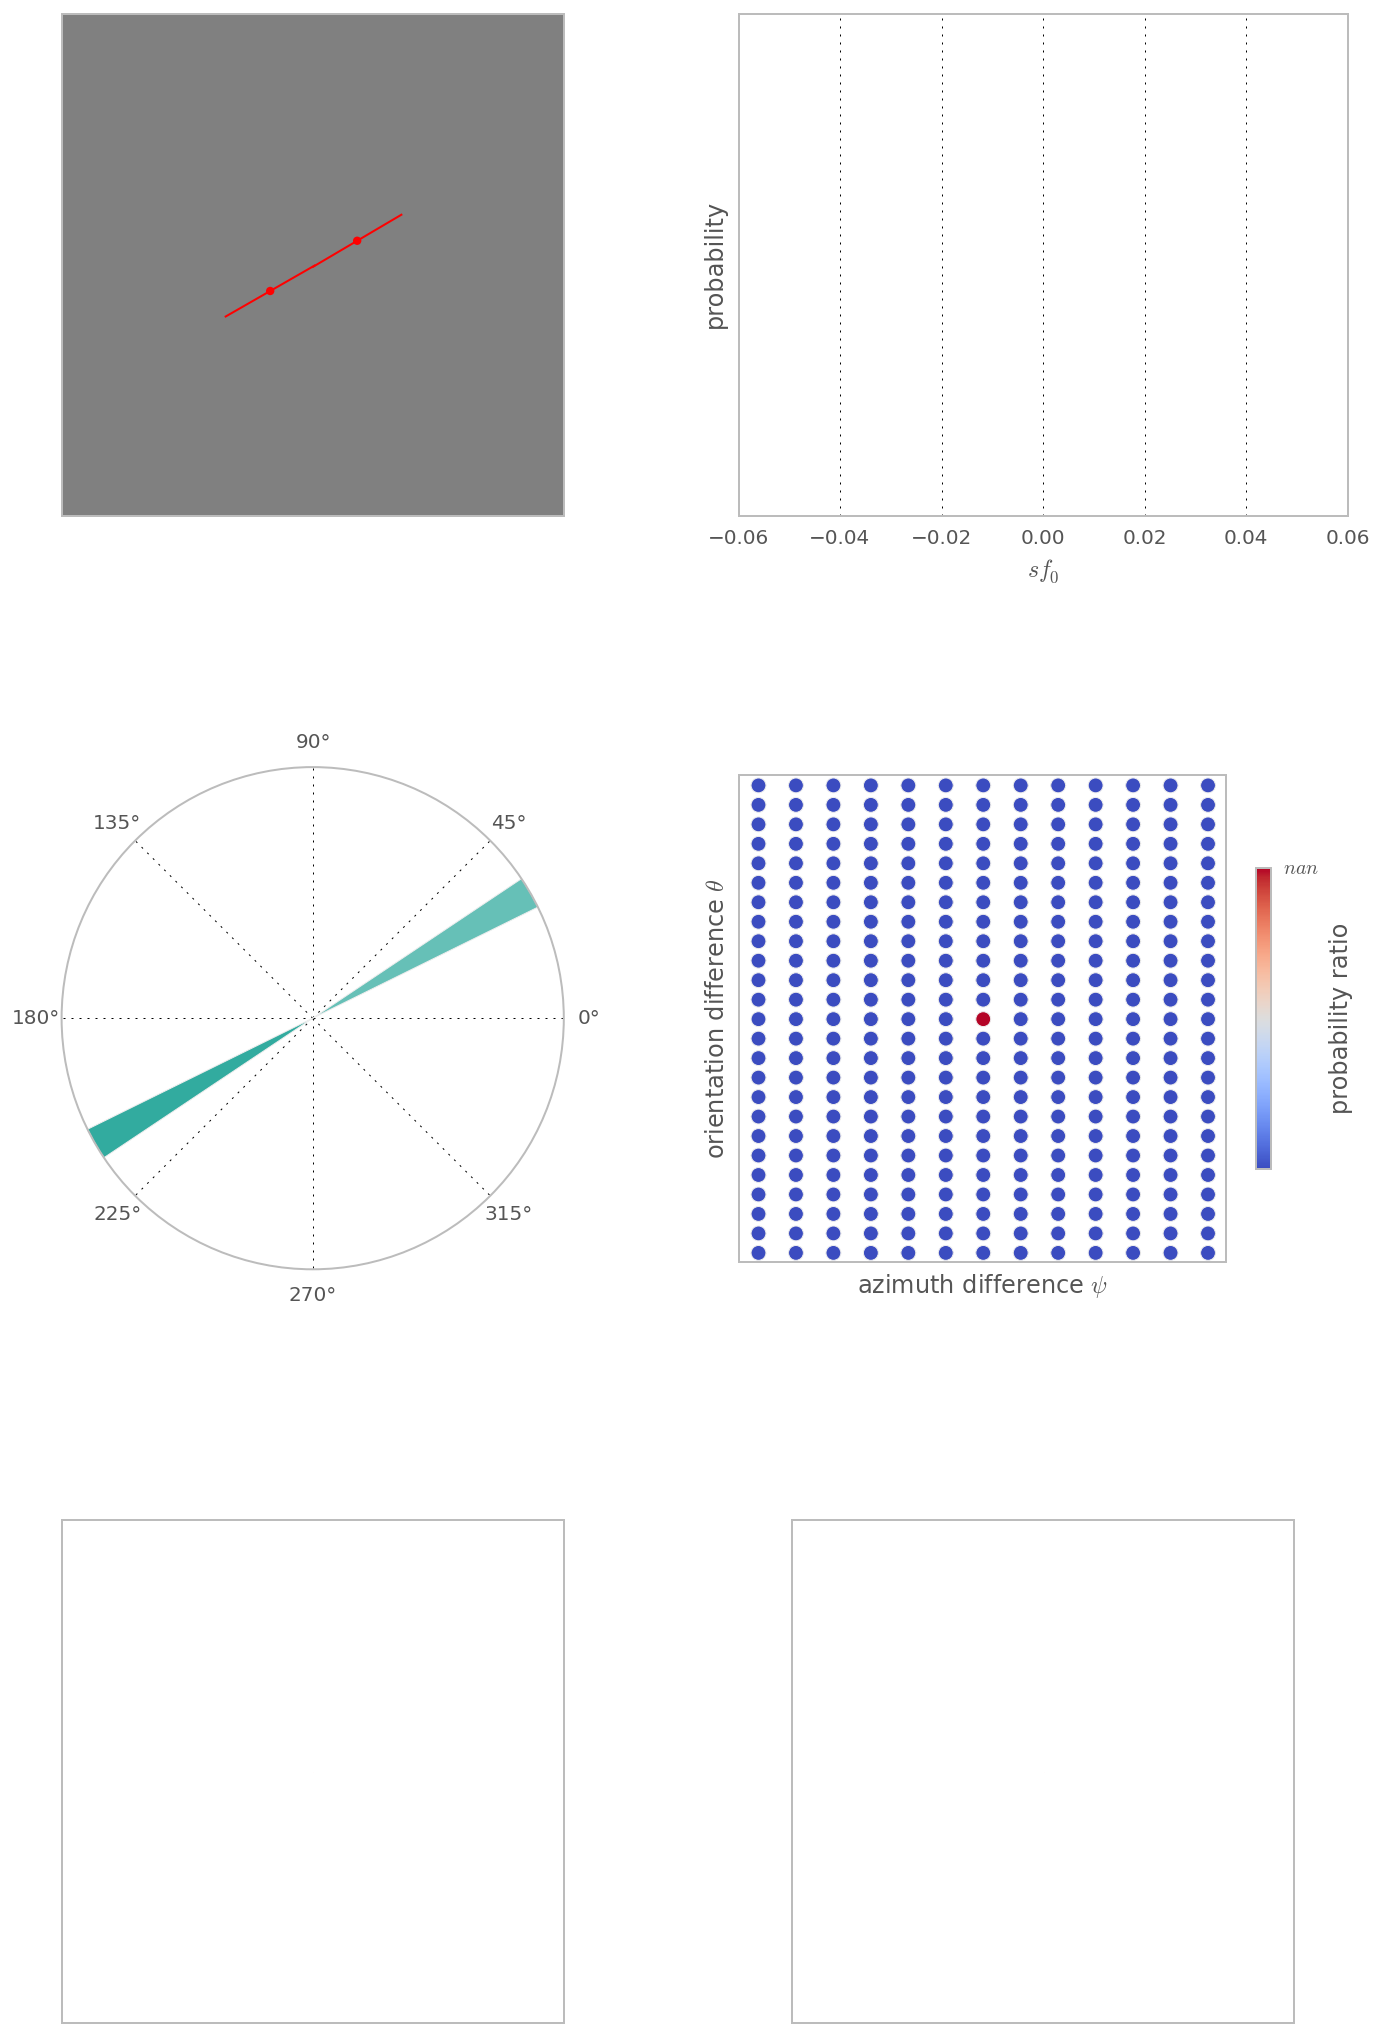

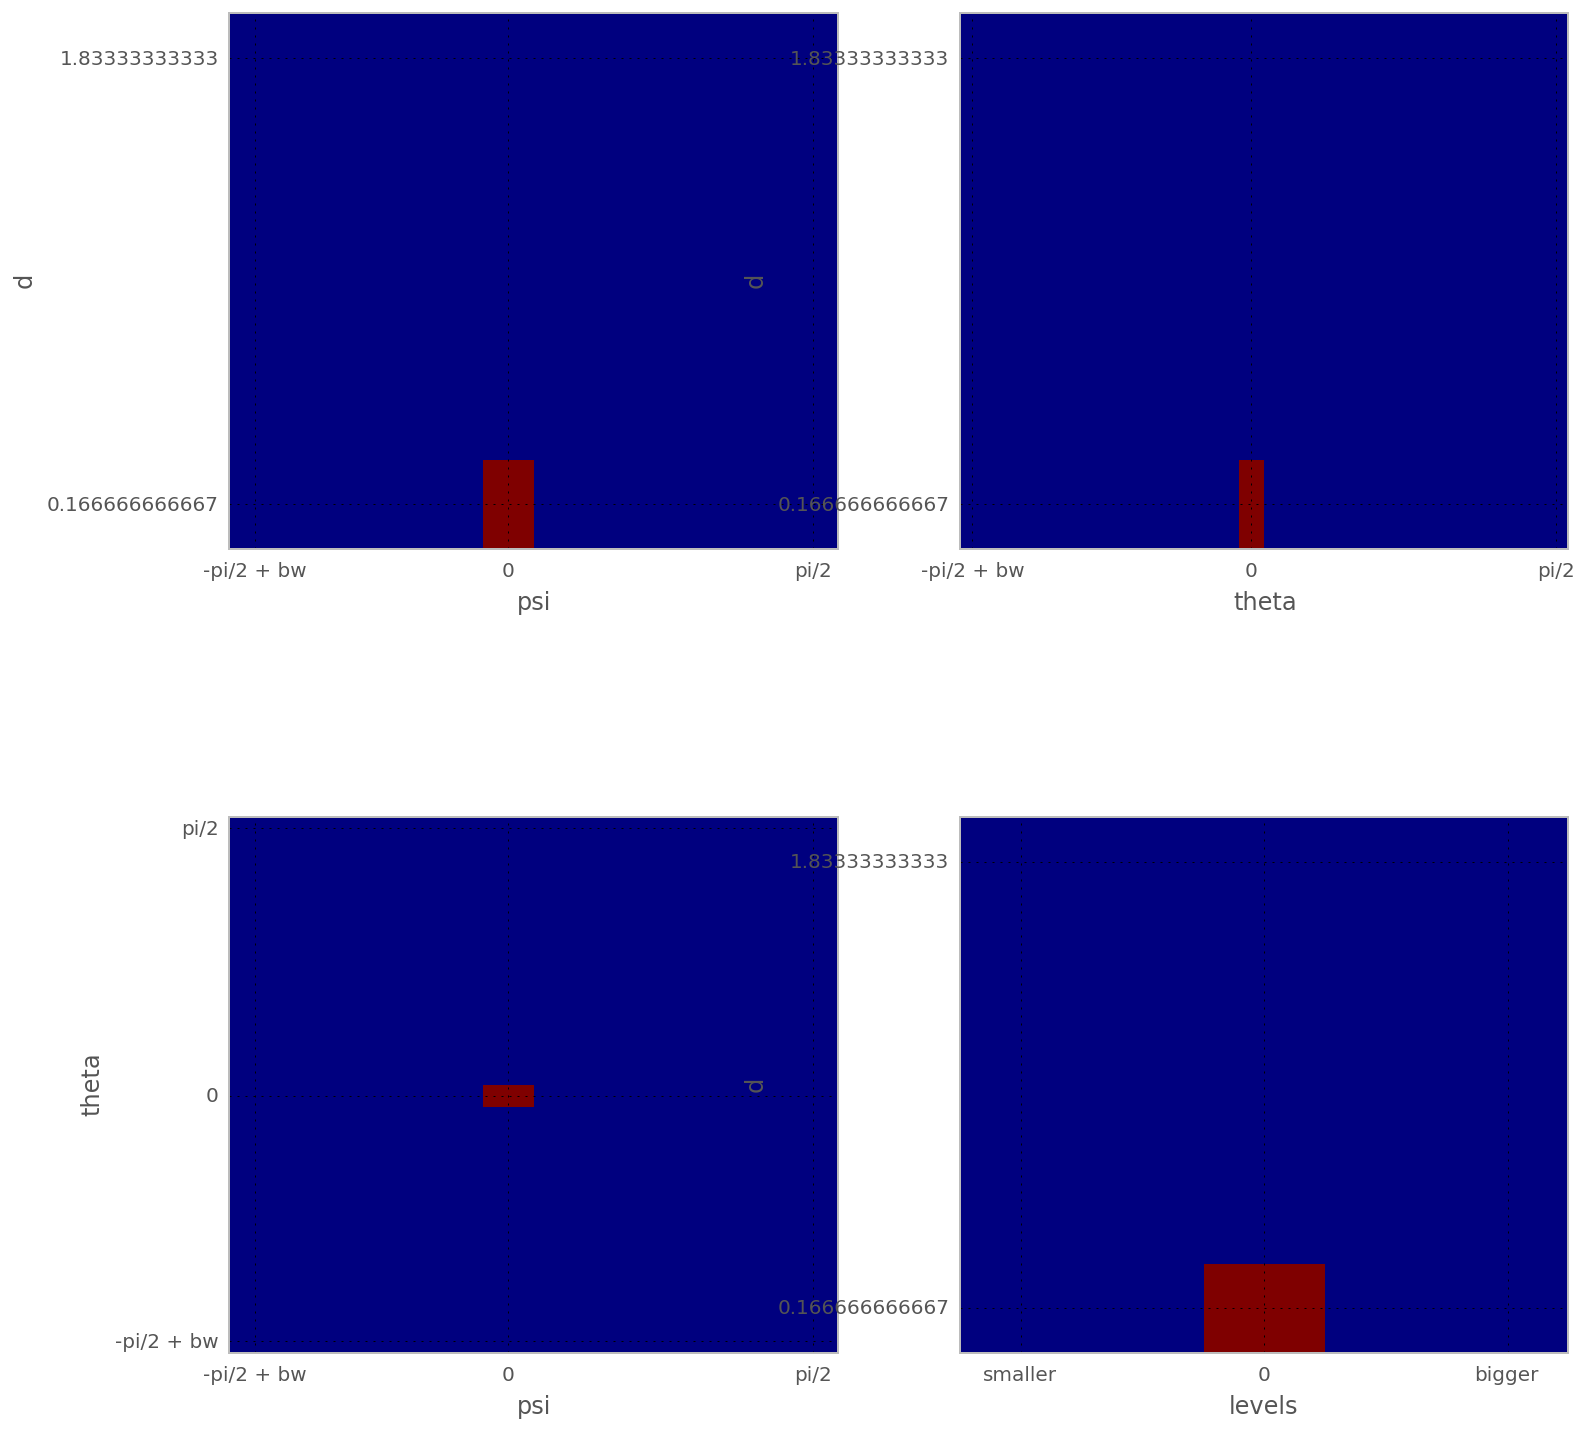

In [26]:
mp = SparseEdges('https://raw.githubusercontent.com/meduz/SparseEdges/master/default_param.py')
mp.pe.N_image = 20
mp.pe.d_max = 2.
mp.pe.d_min = 0.
edgeslist = np.zeros((6, 2, mp.pe.N_image))
angle = np.pi/6
for i_N, sign in enumerate([-1., 1.]):
    edgeslist[0, i_N, :] = mp.N_X *(1/2. + .1 * np.sin(angle) * sign) + .0005 * np.random.randn(mp.pe.N_image)
    edgeslist[1, i_N, :] = mp.N_X *(1/2. - .1 * np.cos(angle) * sign) + .0005 * np.random.randn(mp.pe.N_image)
    edgeslist[2, i_N, :] = (angle + np.pi/360.* np.random.randn(mp.pe.N_image)) % np.pi
    edgeslist[3, i_N, :] = .03
    edgeslist[4, i_N, :] = 1.
#print  edgeslist
v_hist = myplot(edgeslist, mp=mp)
#print v_hist

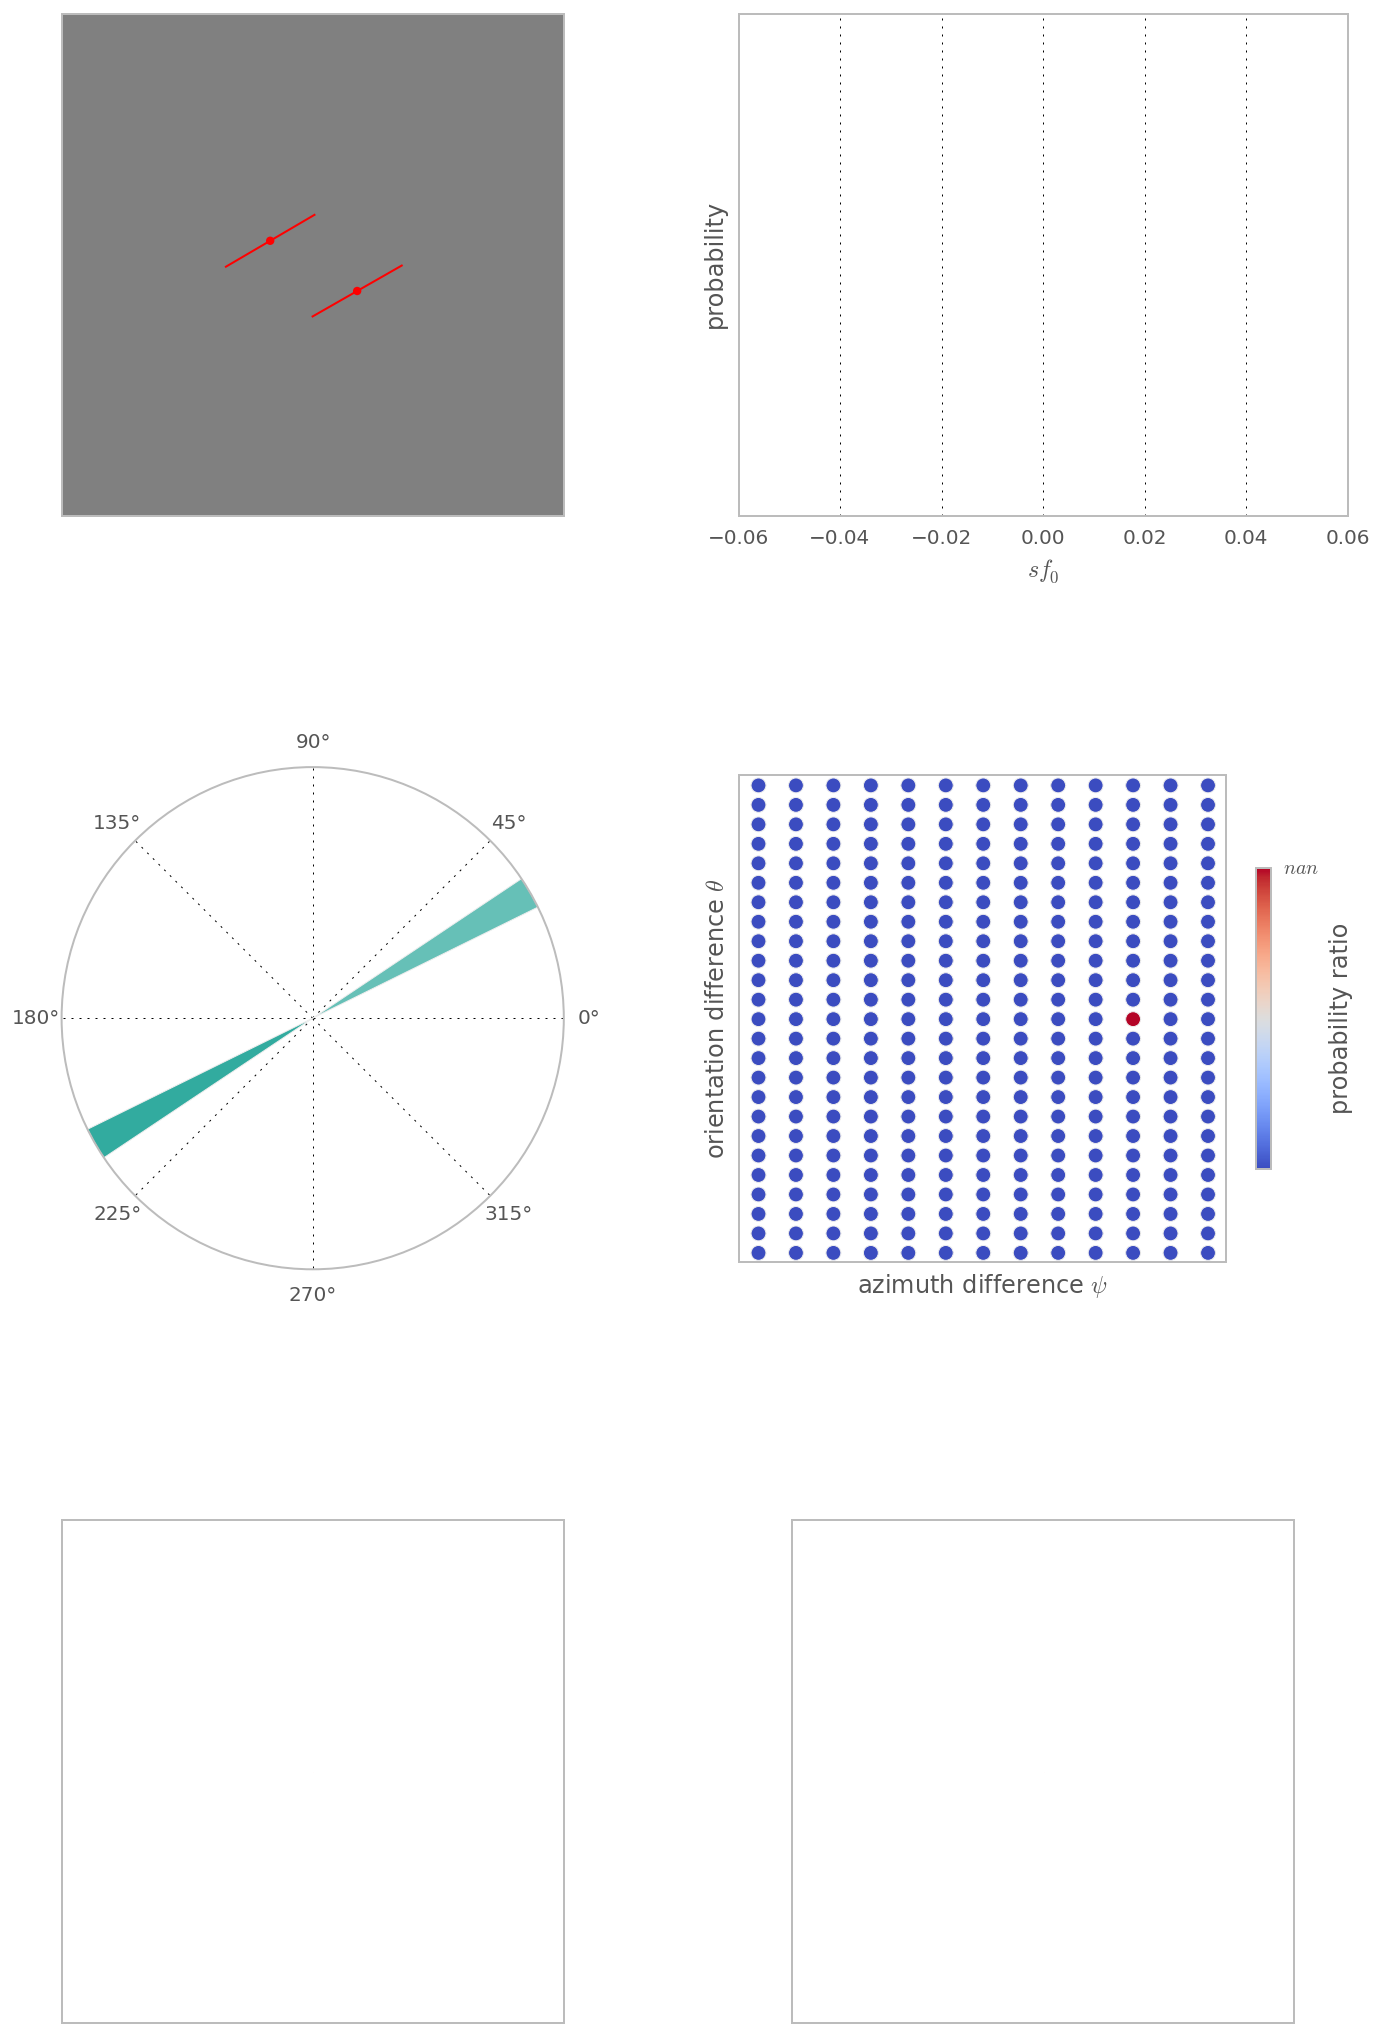

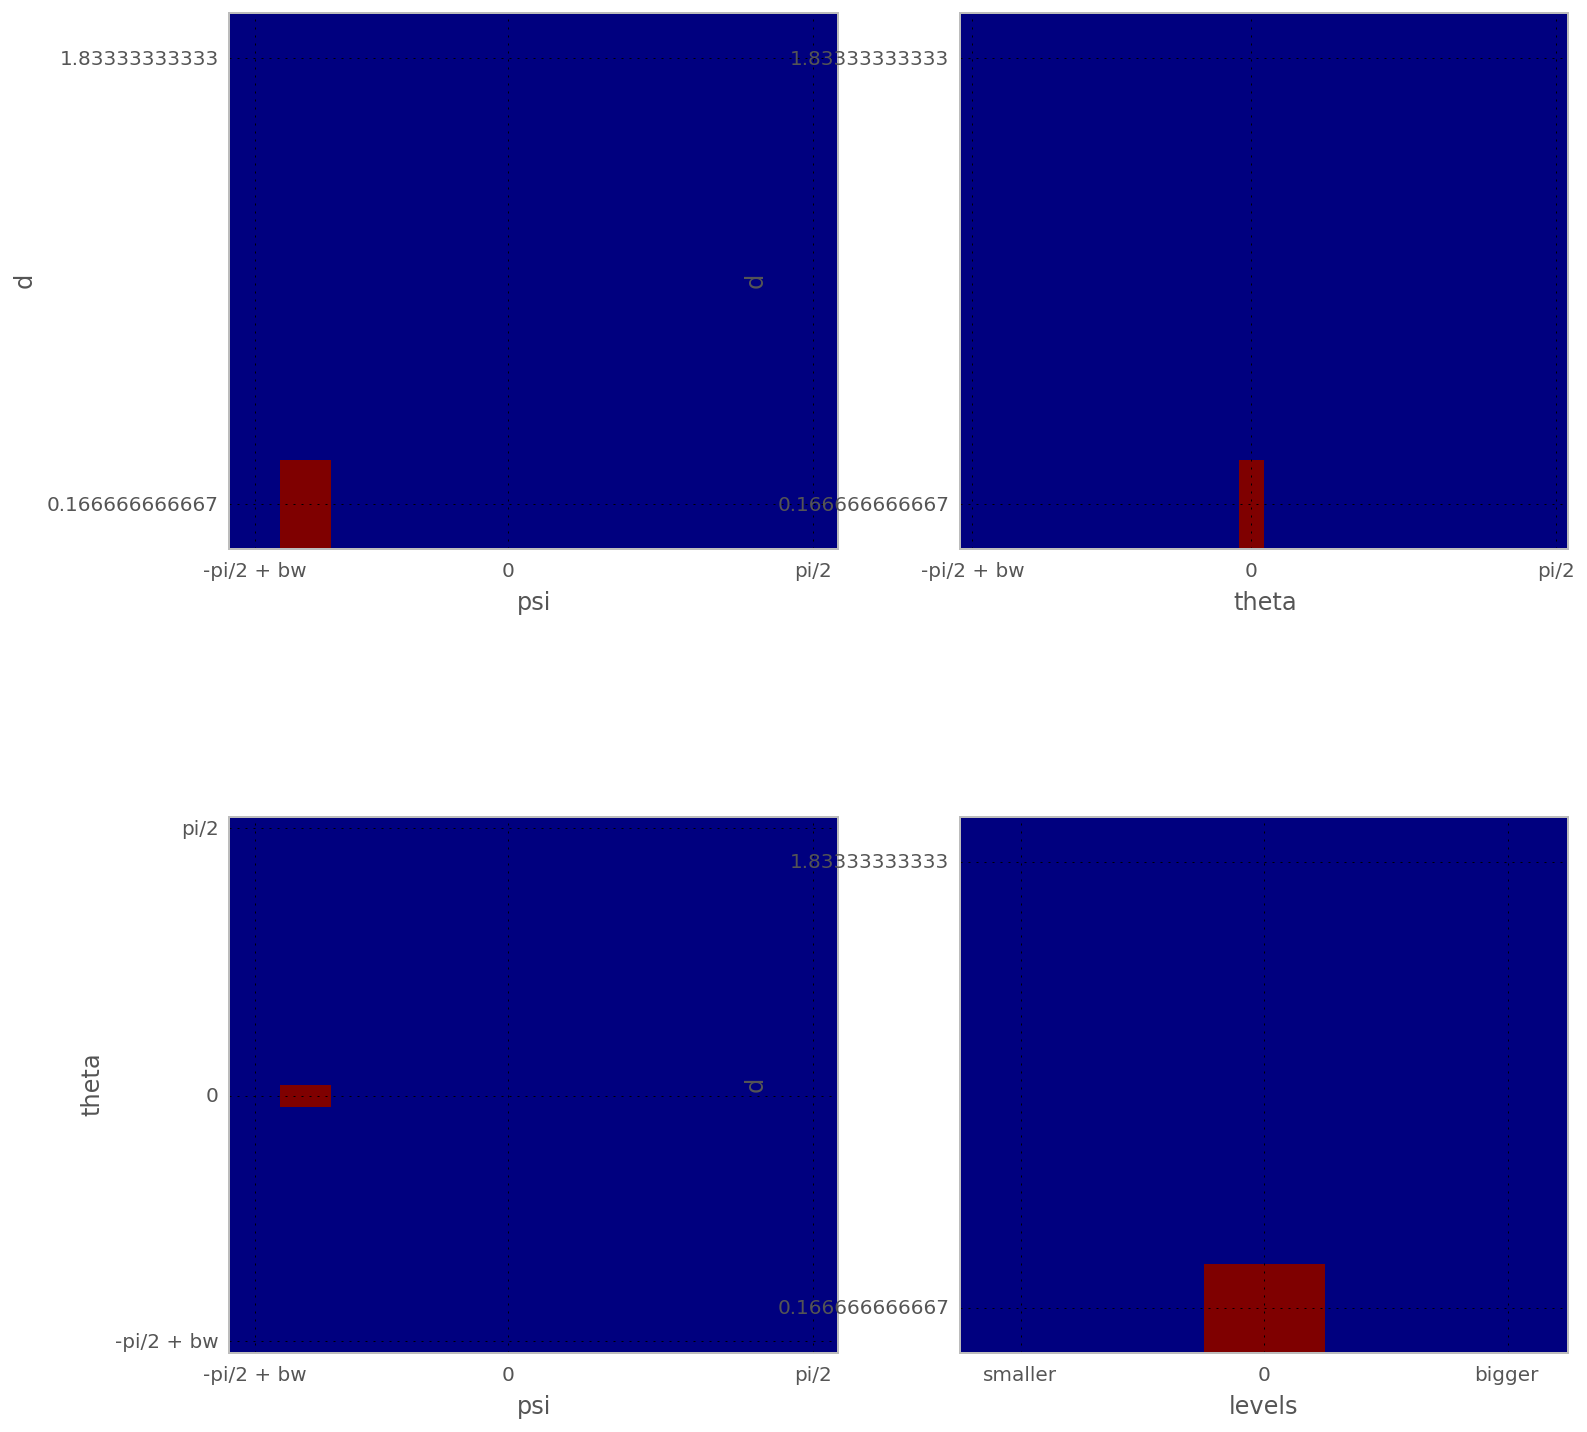

In [27]:
edgeslist = np.zeros((6, 2, mp.pe.N_image))
angle = np.pi/6
for i_N, sign in enumerate([-1., 1.]):
    edgeslist[0, i_N, :] = mp.N_X *(1/2. + .1 * np.sin(angle) * sign) + .0005 * np.random.randn(mp.pe.N_image)
    edgeslist[1, i_N, :] = mp.N_X *(1/2. + .1 * np.cos(angle) * sign) + .0005 * np.random.randn(mp.pe.N_image)
    edgeslist[2, i_N, :] = (angle + np.pi/360.* np.random.randn(mp.pe.N_image)) % np.pi
    edgeslist[3, i_N, :] = .03
    edgeslist[4, i_N, :] = 1.
#print  edgeslist
_ = myplot(edgeslist, mp=mp)

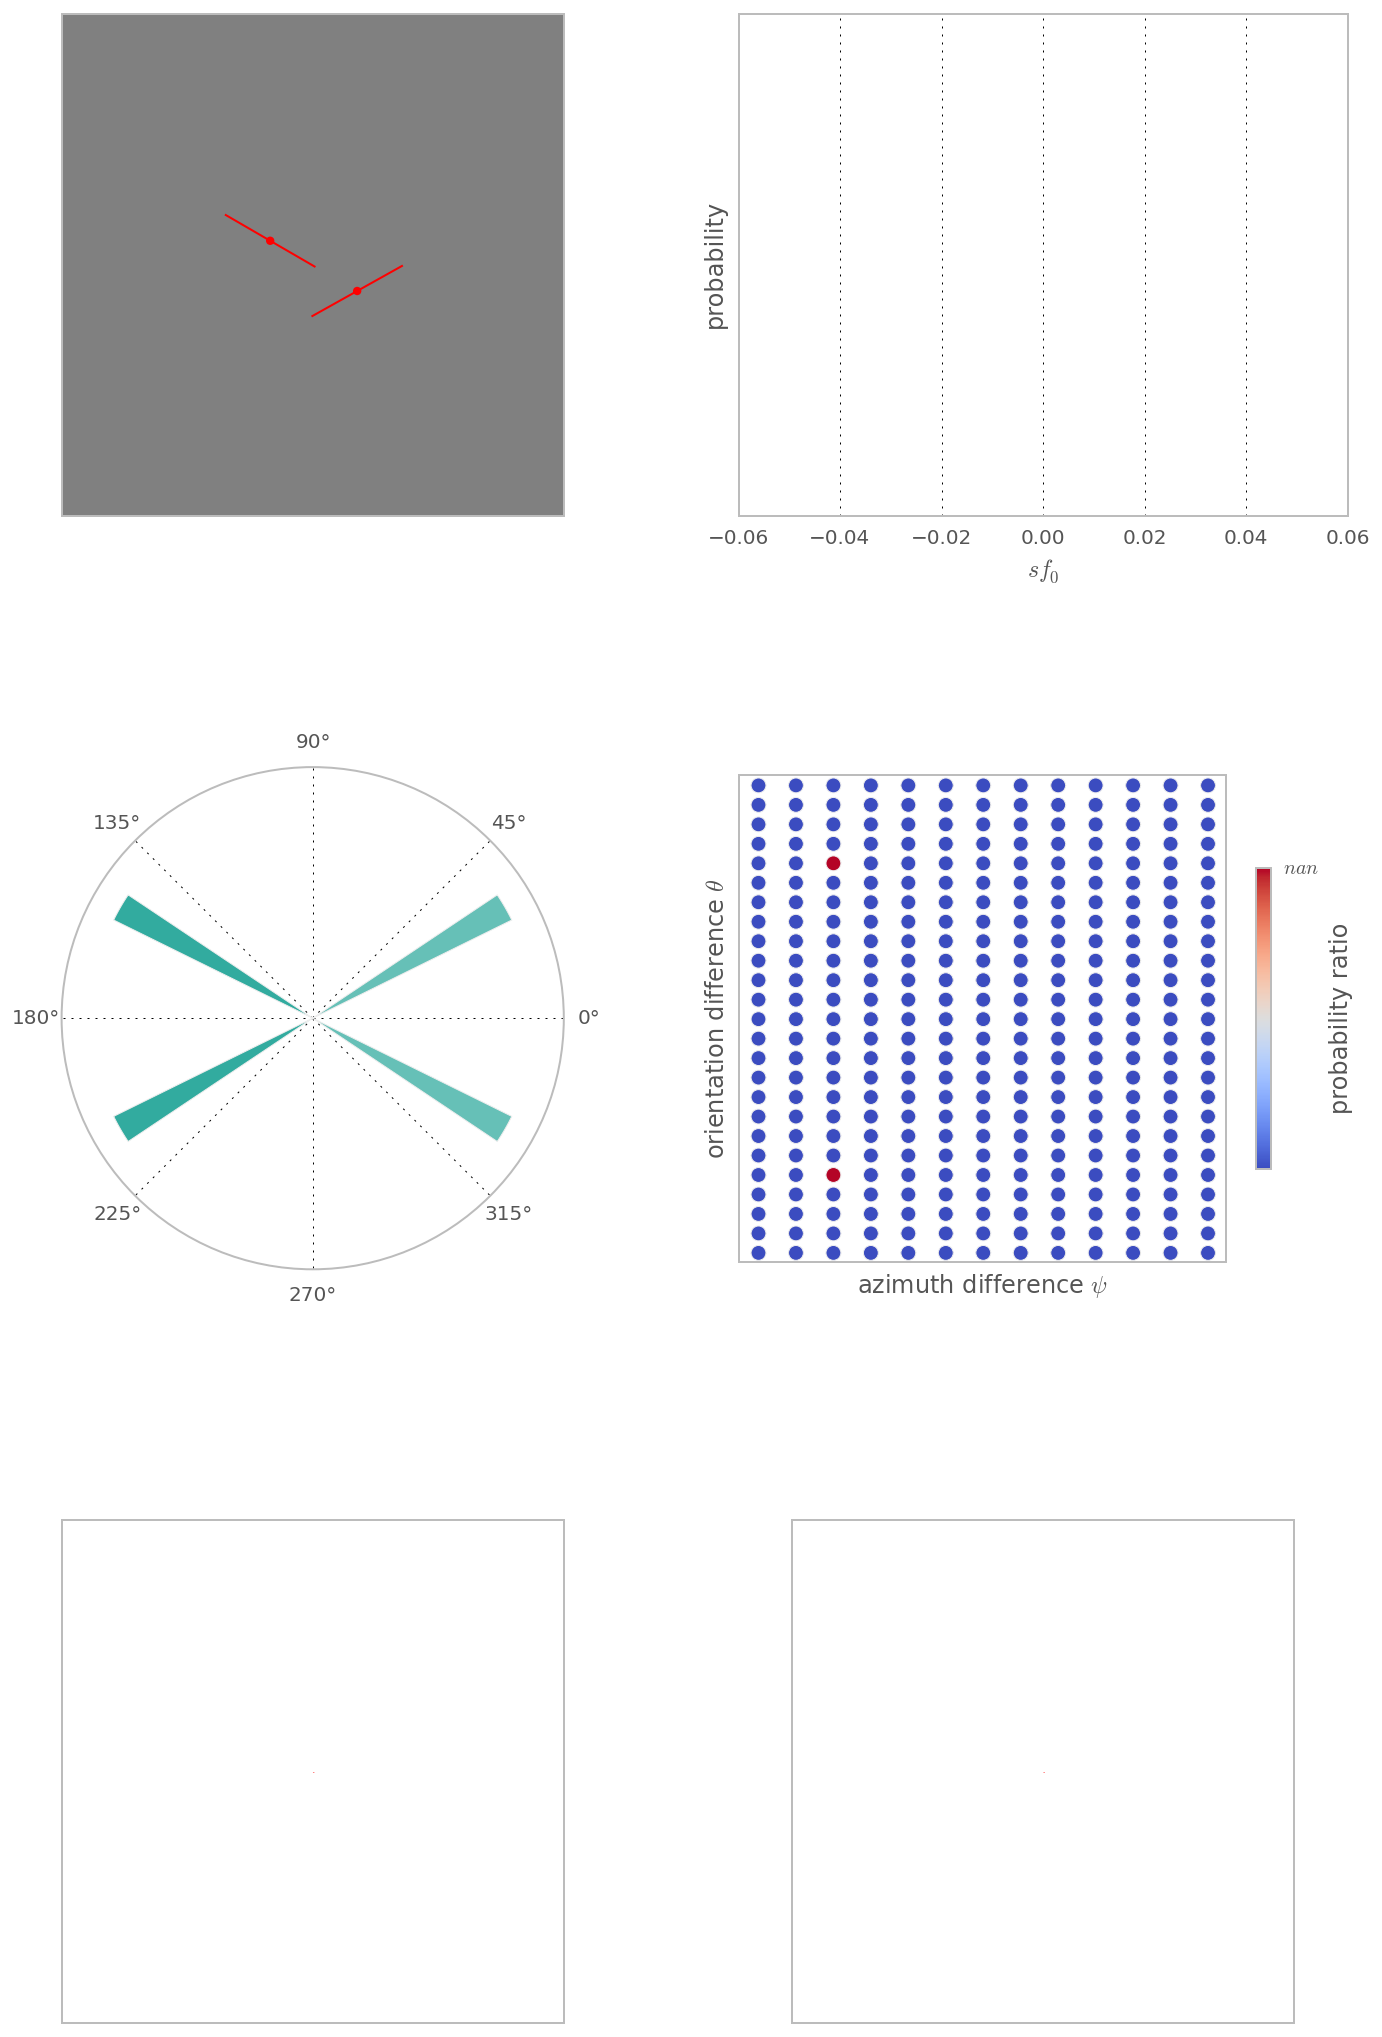

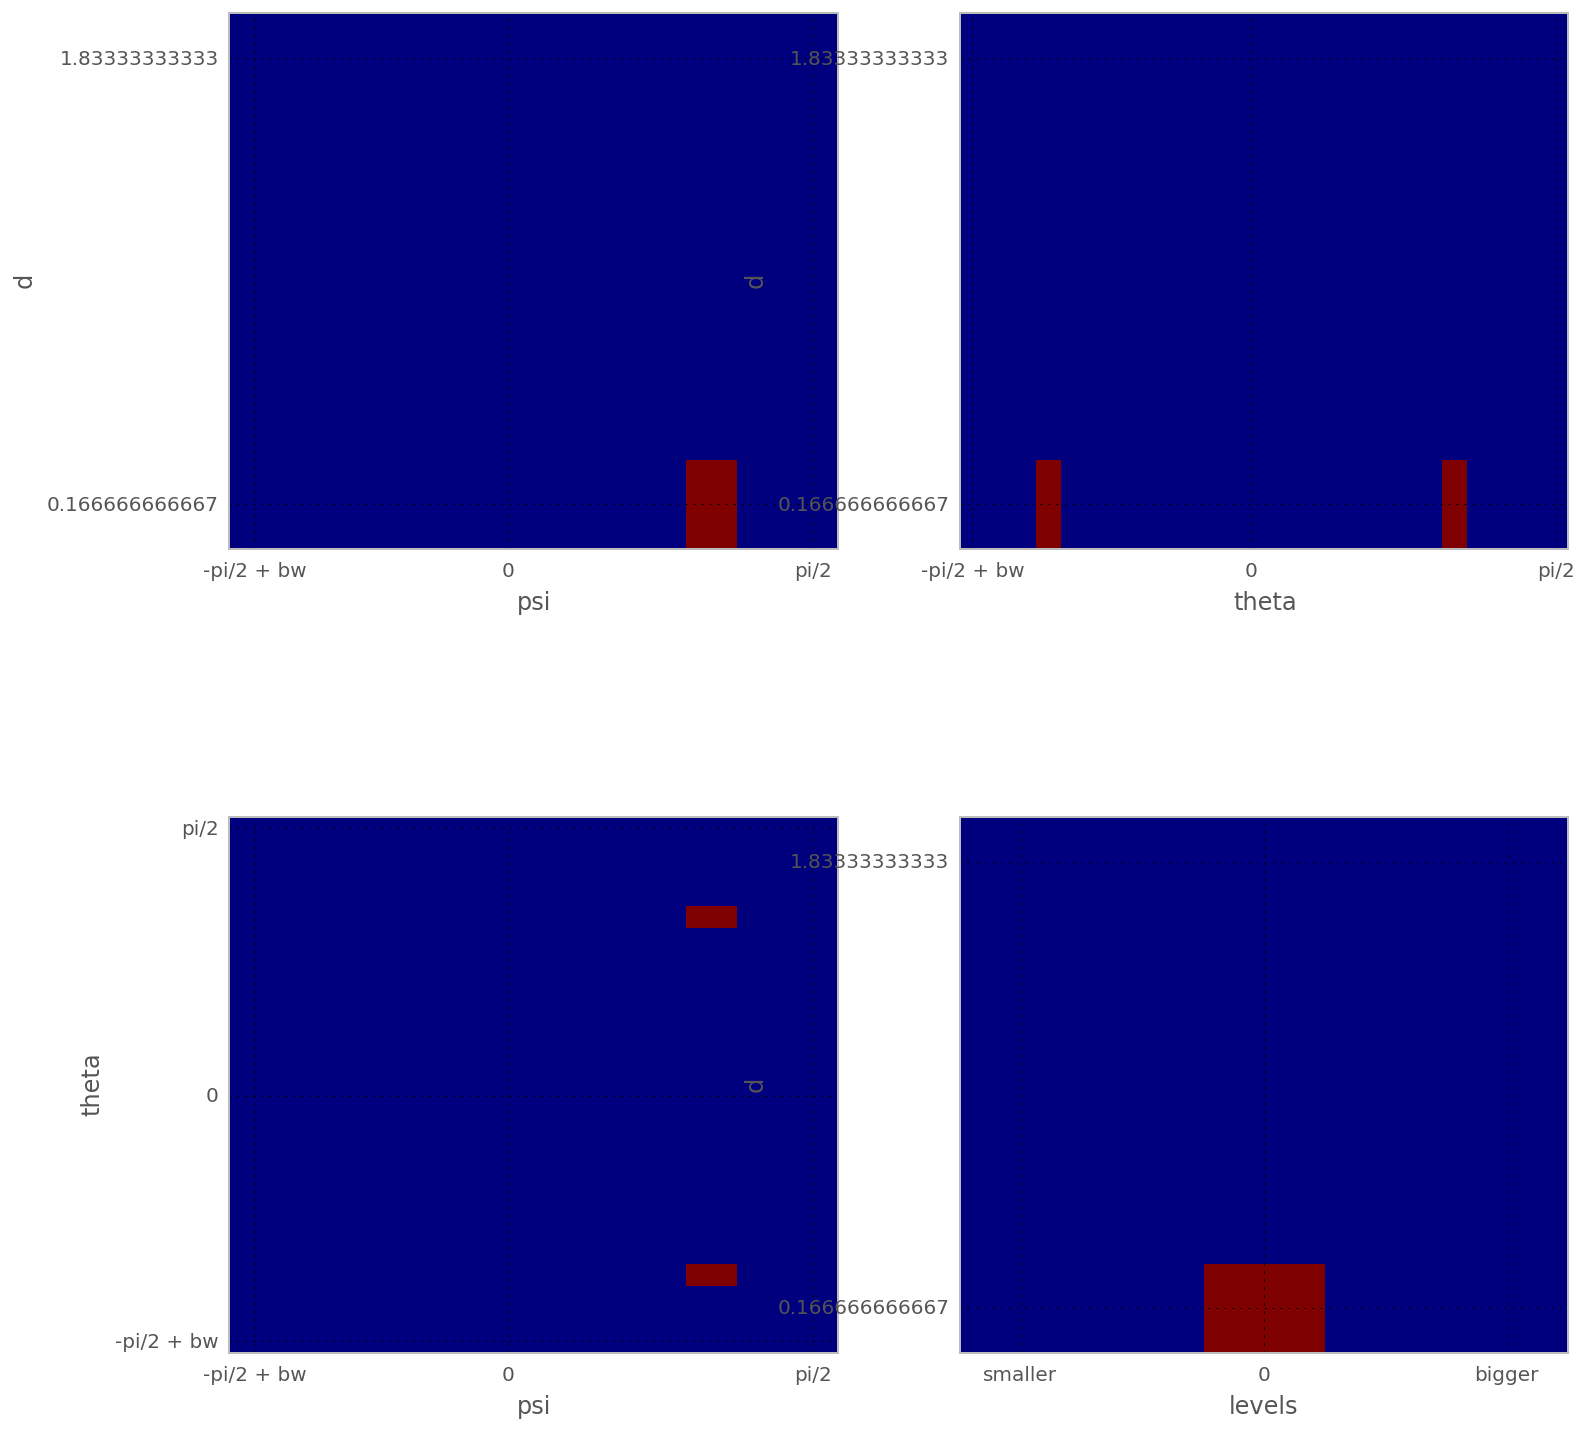

In [28]:
edgeslist = np.zeros((6, 2, mp.pe.N_image))
angle = np.pi/6
for i_N, sign in enumerate([-1., 1.]):
    edgeslist[0, i_N, :] = mp.N_X *(1/2. + .1 * np.sin(angle) * sign) + .0005 * np.random.randn(mp.pe.N_image)
    edgeslist[1, i_N, :] = mp.N_X *(1/2. + .1 * np.cos(angle) * sign) + .0005 * np.random.randn(mp.pe.N_image)
    edgeslist[2, i_N, :] = sign*(angle + np.pi/360.* np.random.randn(mp.pe.N_image)) % np.pi
    edgeslist[3, i_N, :] = .03
    edgeslist[4, i_N, :] = 1.
_ = myplot(edgeslist, mp=mp)

#### random edges

1.618 11


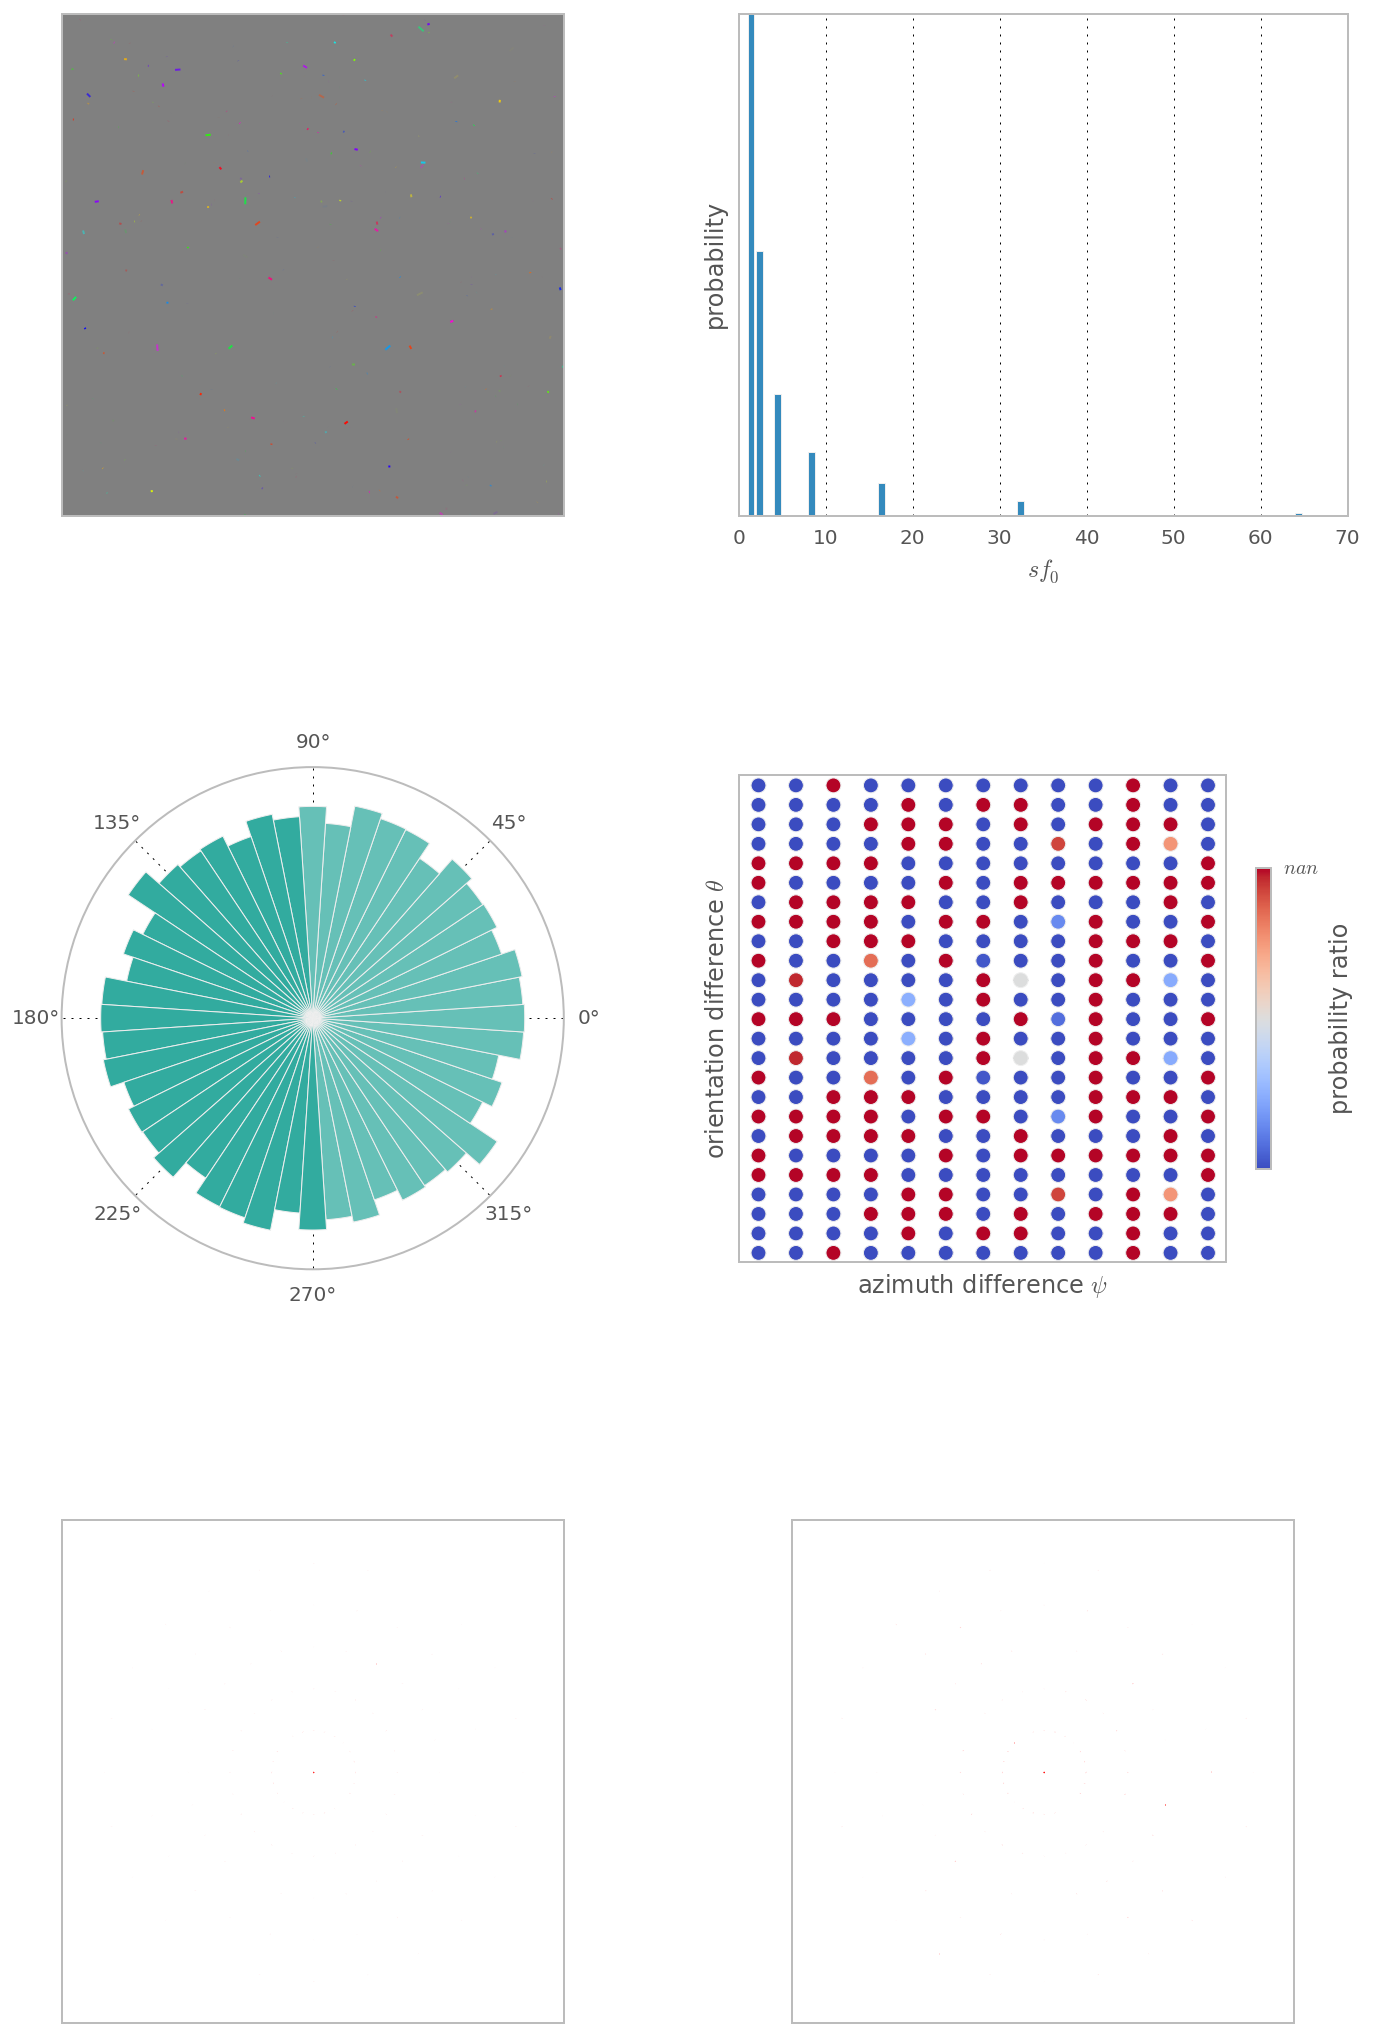

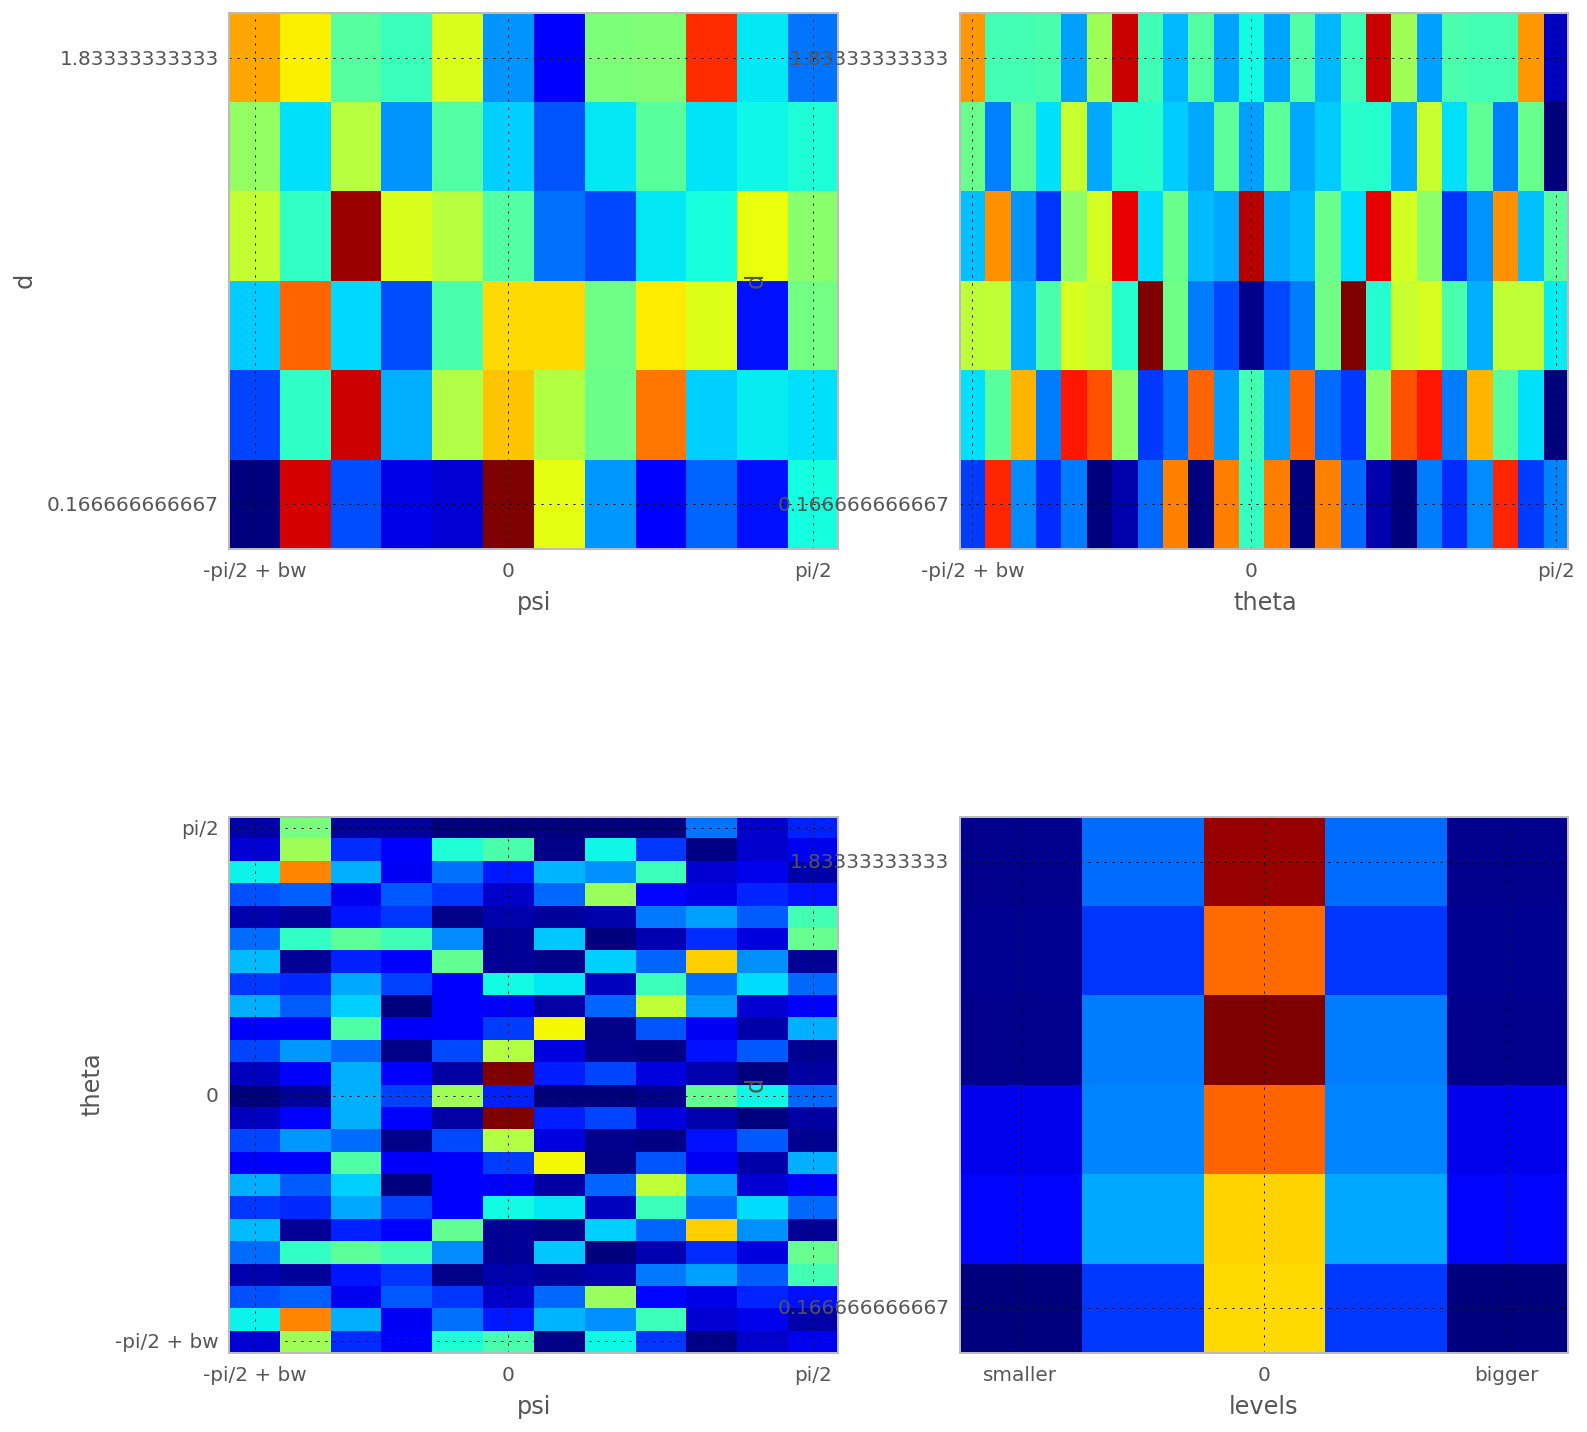

In [29]:
mp.pe.N = 256
print mp.pe.base_levels, mp.n_levels
edgeslist = np.zeros((6, mp.pe.N, mp.pe.N_image))
edgeslist[0, :, :] = mp.N_X * np.random.rand(mp.pe.N, mp.pe.N_image)
edgeslist[1, :, :] = mp.N_X * np.random.rand(mp.pe.N, mp.pe.N_image)
edgeslist[2, :, :] = (np.pi* np.random.rand(mp.pe.N, mp.pe.N_image) ) % np.pi
edgeslist[3, :, :] =  .03*np.ceil(mp.pe.base_levels**(mp.n_levels*(np.random.rand(mp.pe.N, mp.pe.N_image)+.5)))
edgeslist[4, :, :] = np.random.rand(mp.pe.N, mp.pe.N_image) 
edgeslist[5, :, :] = 2*np.pi*np.random.rand(mp.pe.N, mp.pe.N_image)

_ = myplot(edgeslist, mp=mp)

#### parallel edges

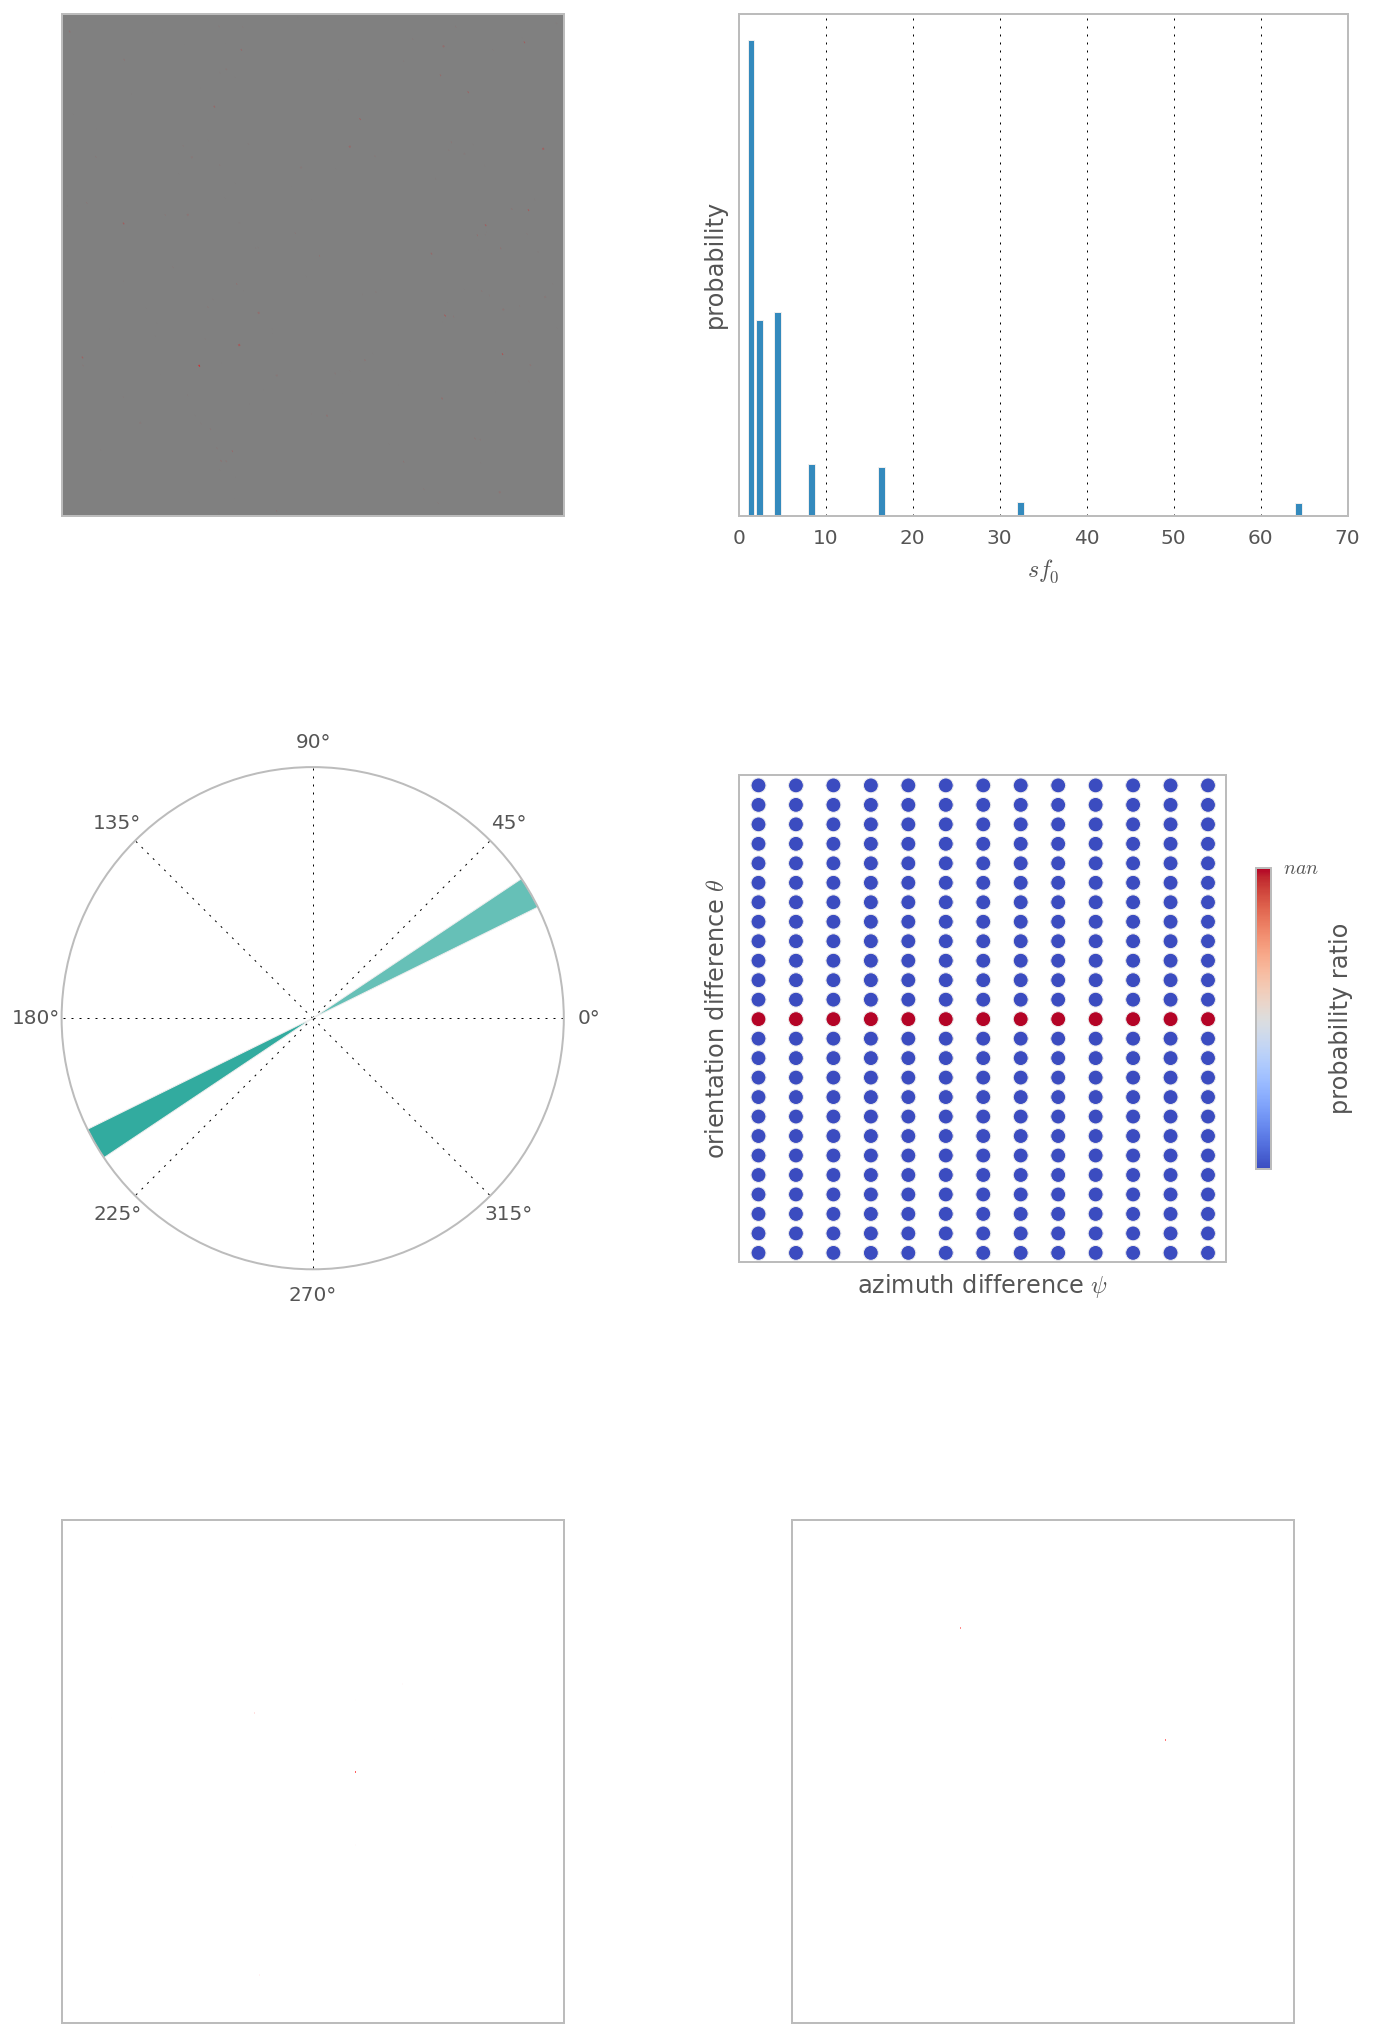

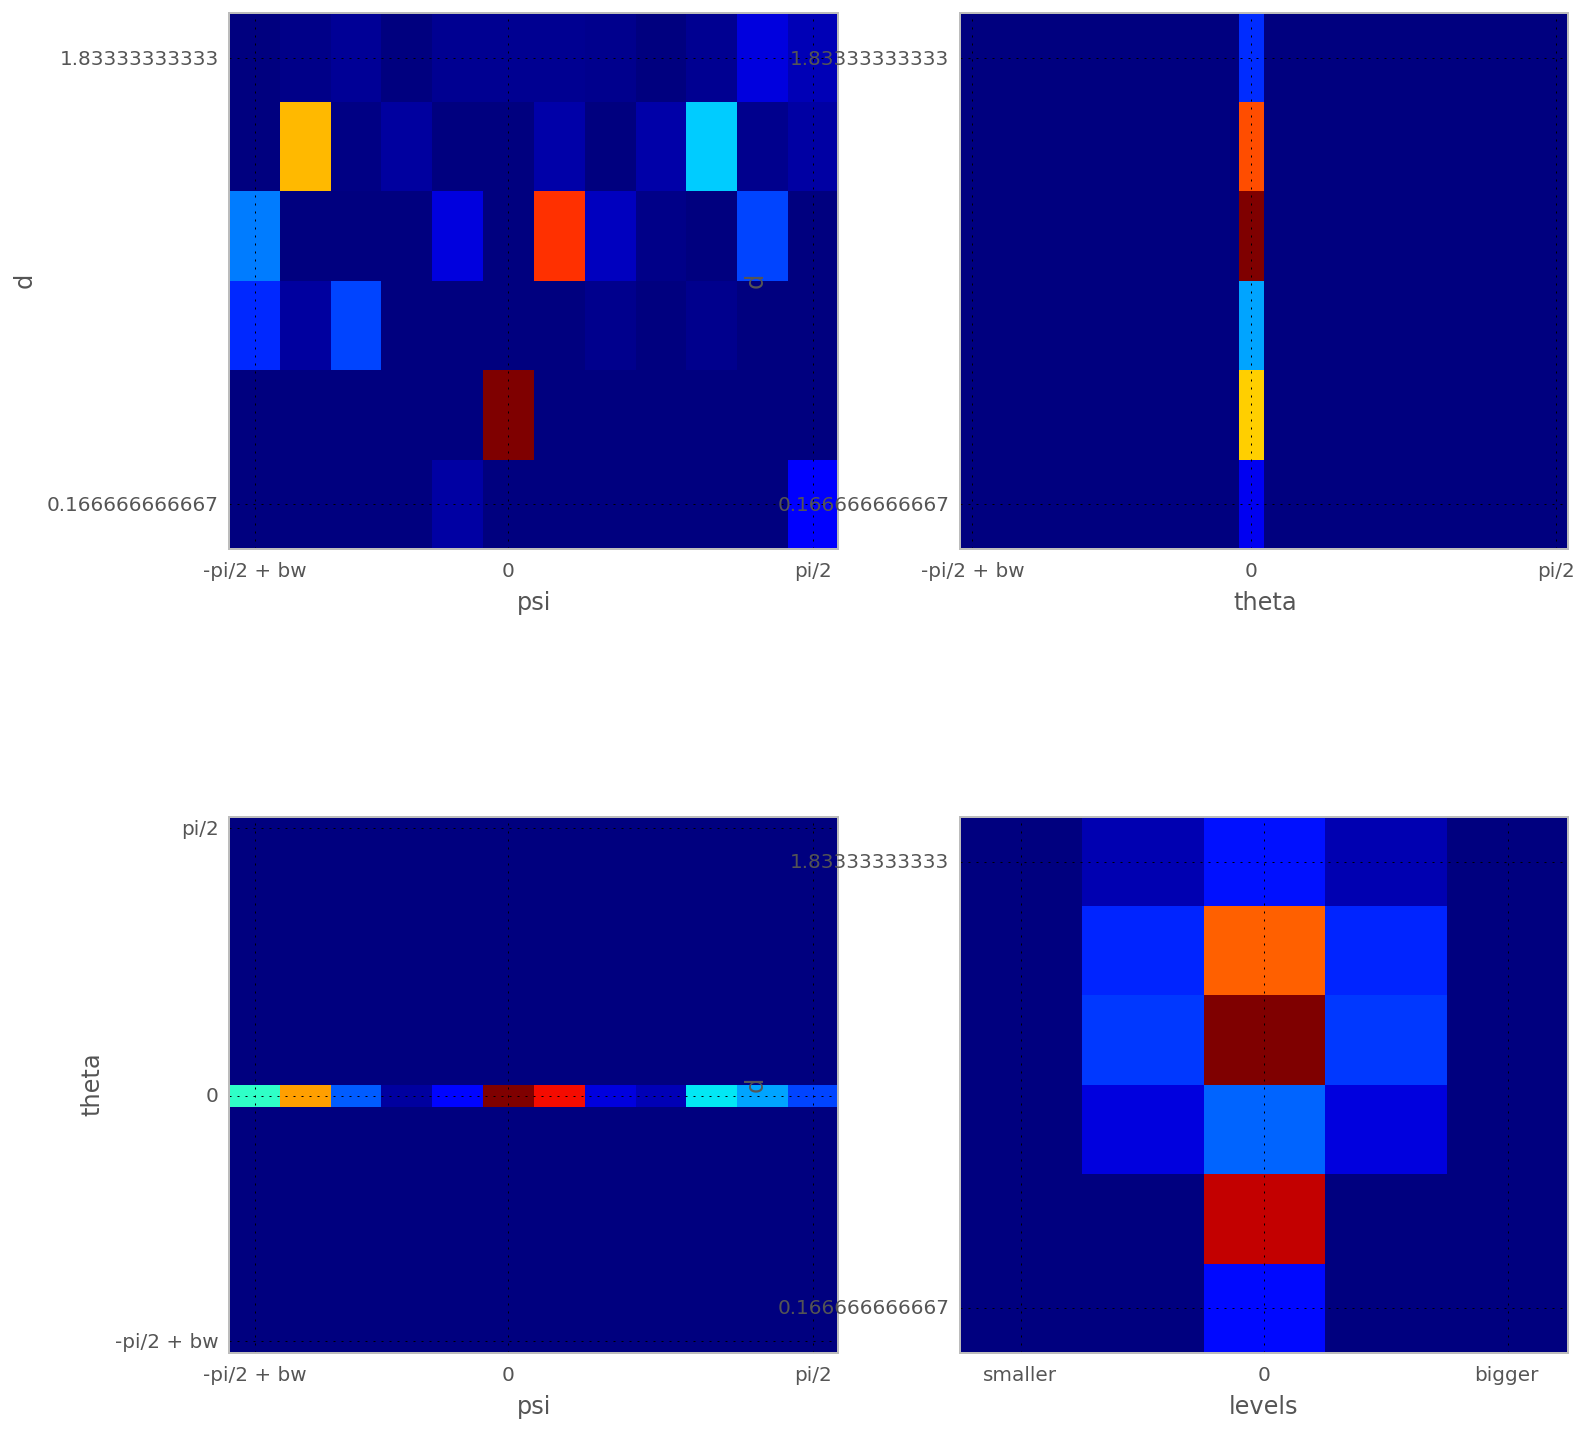

In [30]:
edgeslist = np.zeros((6, mp.pe.N, mp.pe.N_image))
for i_N, x in enumerate(np.linspace(-mp.N_X/4., mp.N_X/4., mp.pe.N)):
    edgeslist[0, i_N, :] = mp.N_X * np.random.rand(mp.pe.N_image)
    edgeslist[1, i_N, :] = mp.N_X * np.random.rand(mp.pe.N_image)
    edgeslist[2, i_N, :] = (np.pi/6 + np.pi/360.* np.random.randn(mp.pe.N_image) ) % np.pi
    edgeslist[3, i_N, :] = mp.pe.base_levels**np.ceil(mp.n_levels*np.random.rand(mp.pe.N_image))
    edgeslist[4, i_N, :] = np.random.randn(mp.pe.N_image)**2
#! show one sample
_ = myplot(edgeslist, mp=mp)

#print mp.cohistedges(edgeslist, display='none')

#### colinear edges

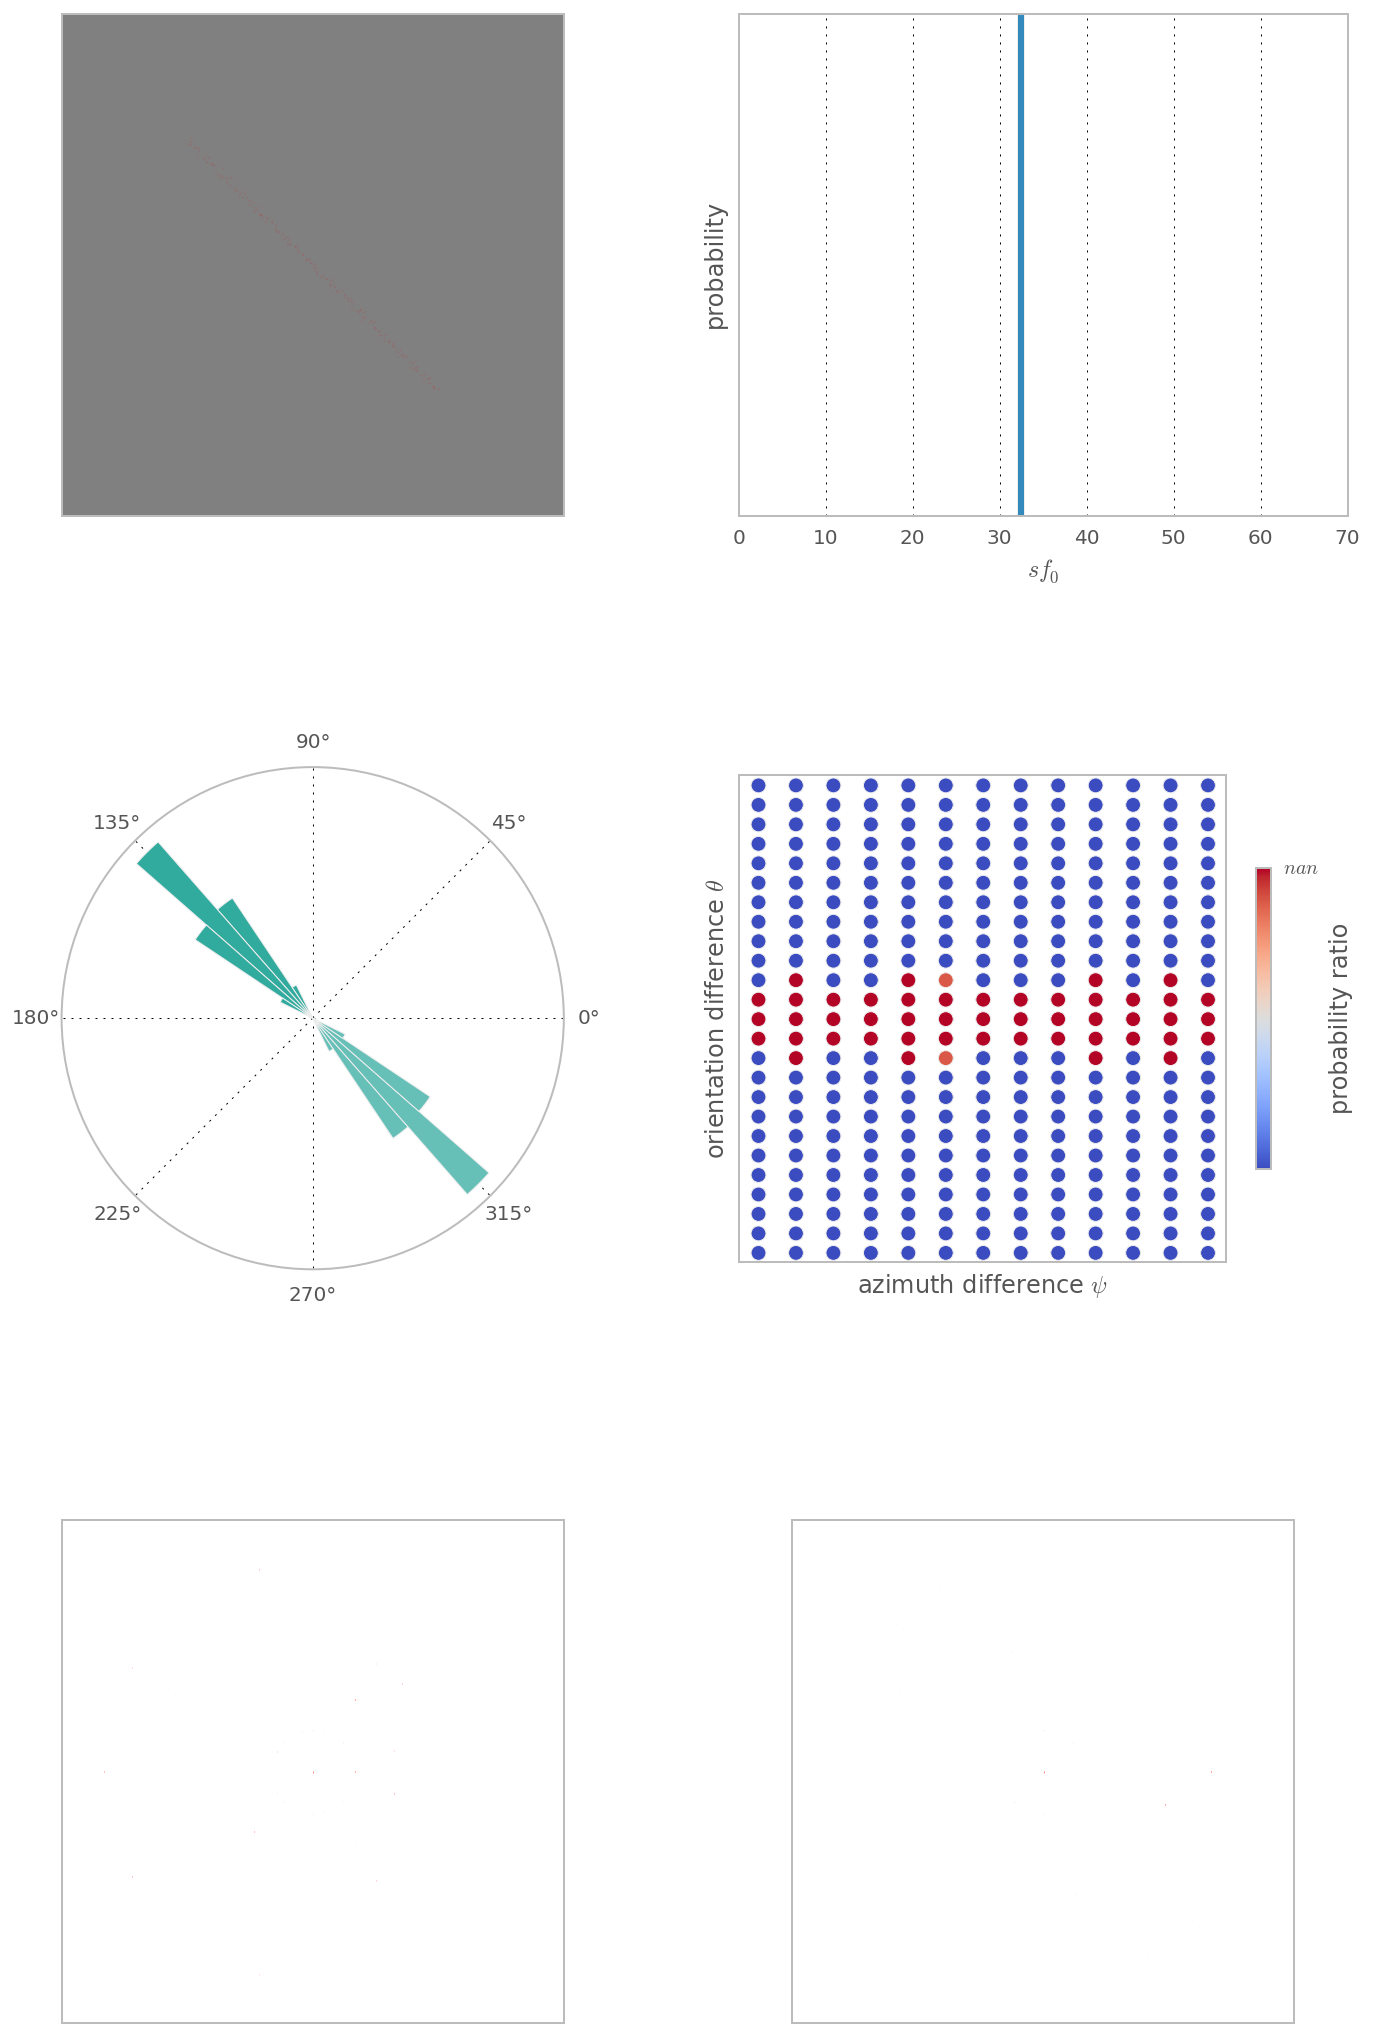

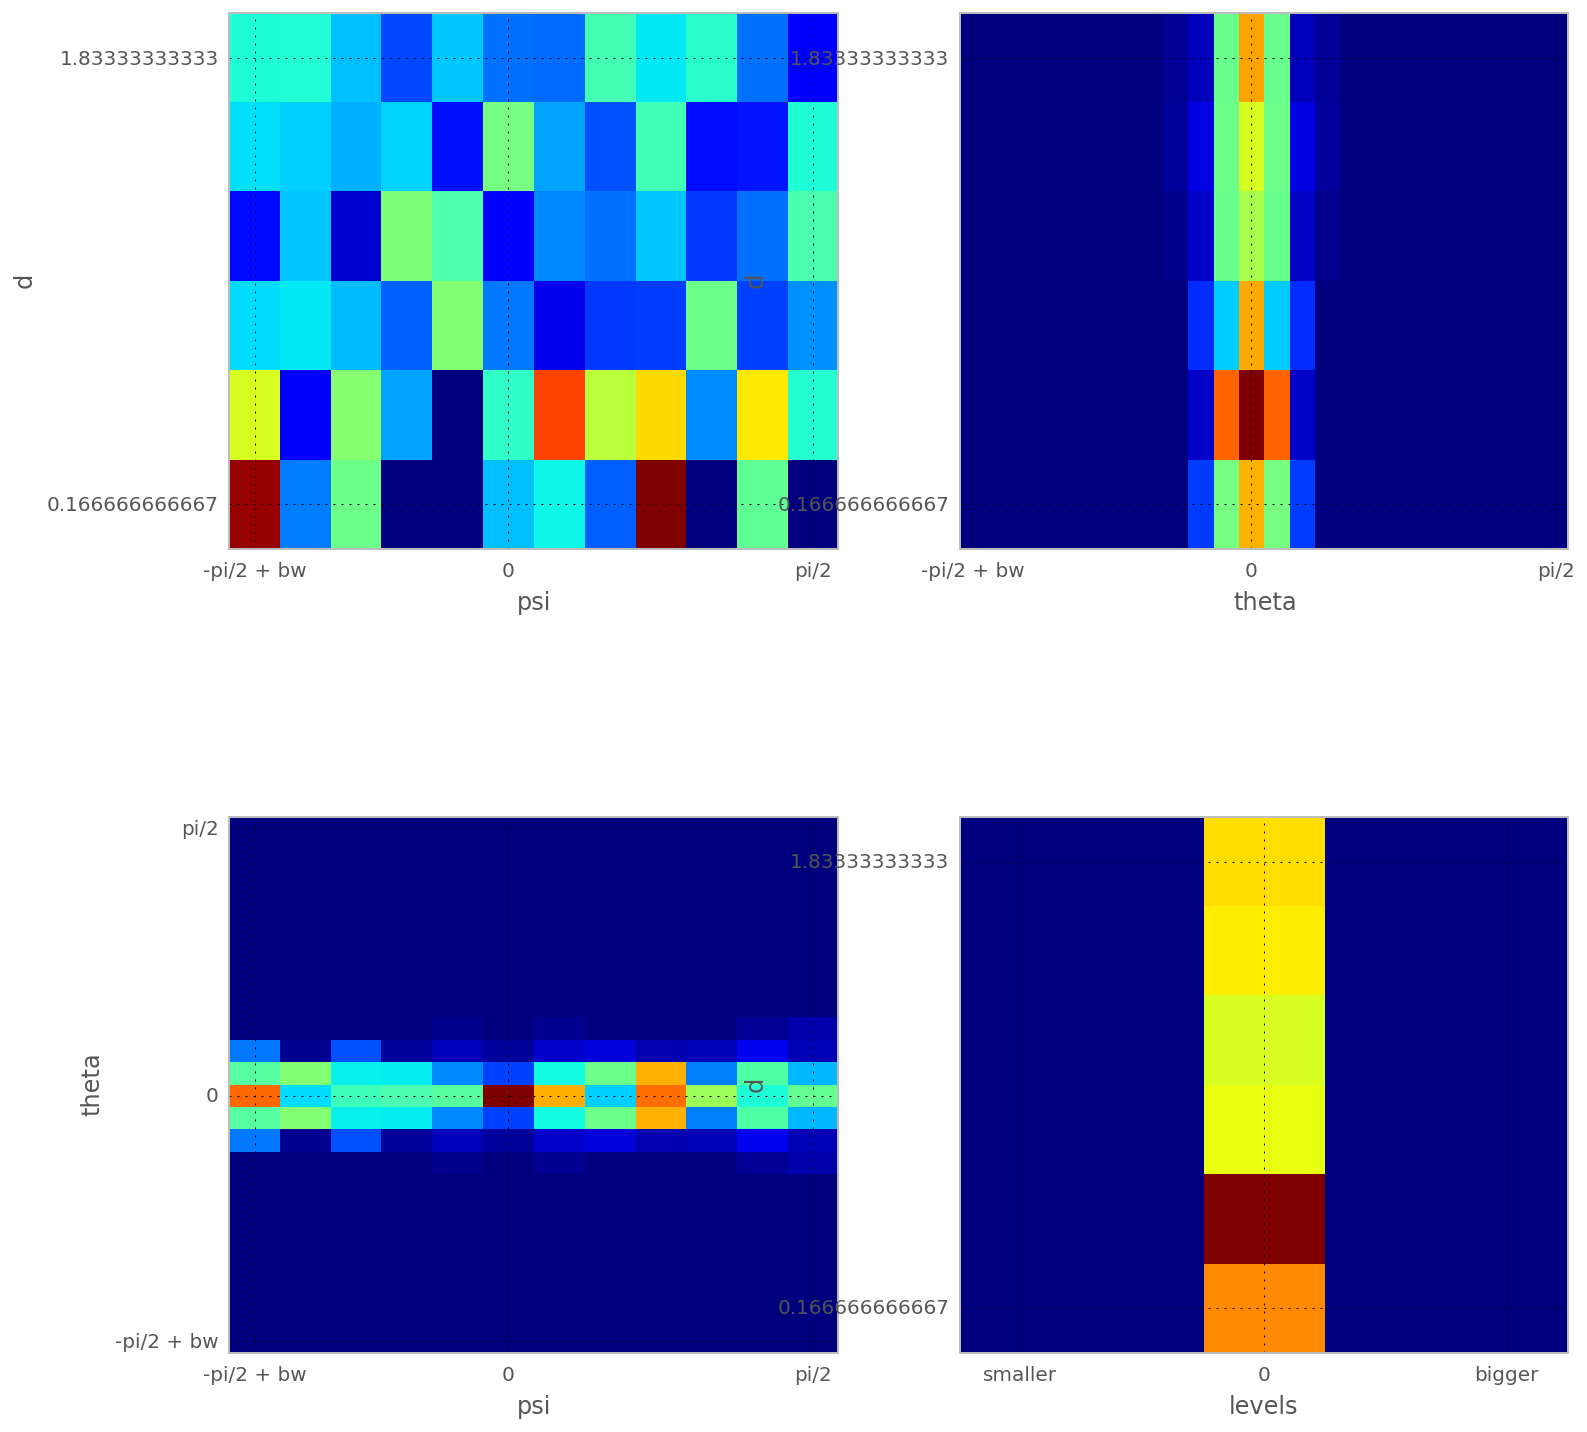

In [31]:
edgeslist = np.zeros((6, mp.pe.N, mp.pe.N_image))
for i_N, x in enumerate(np.linspace(-mp.N_X/4., mp.N_X/4., mp.pe.N)):
    edgeslist[0, i_N, :] = mp.N_X/2. + x + 1. * np.random.randn(mp.pe.N_image)
    edgeslist[1, i_N, :] = mp.N_X/2. + x + 1. * np.random.randn(mp.pe.N_image)
    edgeslist[2, i_N, :] = (-np.pi/4 + np.pi*5./180.* np.random.randn(mp.pe.N_image) ) % np.pi
    edgeslist[3, i_N, :] = 32. #np.sqrt(2.)/2 * N_X / N
    edgeslist[4, i_N, :] = 1.
_ = myplot(edgeslist, mp=mp)#

In [32]:
def full_hist(edgeslist, **kwargs):
        v_hist = np.zeros((mp.pe.N_r, mp.pe.N_phi, mp.pe.N_Dtheta, mp.pe.N_scale, edgeslist.shape[2])) # bins=(self.edges_d, self.edges_phi, self.edges_theta, self.edges_loglevel)
        for i_image in range(edgeslist.shape[2]):
            v_hist[..., i_image] = mp.cohistedges(edgeslist[:, :, i_image][..., np.newaxis], display='none', **kwargs)
            v_hist[..., i_image] /= v_hist[..., i_image].sum()
        return v_hist

In [33]:
#! using first database
#print im.get_imagelist(exp='testing_vanilla', name_database='serre07_distractors')
#!ls mat/edges/testing_vanilla_serre07_distractors/

#### plotting with distractors

In [34]:
#edgeslist = np.load('../AssoField/mat/classifier_serre07_distractors_edges.npy')
imageslist, edgeslist, RMSE = mp.process(exp='Sparselets', name_database='serre07_distractors')

INFO:SLIP: > computing edges for experiment Sparselets with database serre07_distractors 
INFO:SLIP:>>> For the class serre07_distractors, in experiment Sparselets RMSE = 0.043332 


In [35]:
#_ = myplot(edgeslist[:, :, 0][:, :, np.newaxis], pe=pe)

In [36]:
#!rm mat/testing_vanilla_serre07_distractors_hist.npy*
matname = 'mat/Sparselets_serre07_distractors_hist.npy'
try:
    v_hist = np.load(matname)
except Exception, e:
    import os
    if not(os.path.isfile(matname + '_lock')):
        print 'There is no histogram, creating one: ', e
        file(matname + '_lock', 'w').close() # touching
        v_hist = myplot(edgeslist, pe=pe)
        np.save(matname, v_hist)
        os.remove(matname + '_lock')
    else:
        print ' Some process is building the histogram ' + matname    

#### the same with more noise

In [37]:
imageslist, edgeslist, RMSE = mp.process(exp='testing_noise', name_database='serre07_distractors')

matname = 'mat/testing_noise_vanilla_serre07_distractors_hist.npy'
try:
    v_hist = np.load(matname)
except Exception, e:
    if not(os.path.isfile(matname + '_lock')):
        print 'There is no histogram, creating one: ', e
        file(matname + '_lock', 'w').close() # touching
        v_hist = myplot(edgeslist, pe=pe)
        np.save(matname, v_hist)
        os.remove(matname + '_lock')
    else:
        print ' Some process is building the histogram ' + matname

       
#edgeslist = np.load('../AssoField/mat/classifier_noise_serre07_targets_edges.npy')
#! show one sample
#fig, a = mp.show_edges(edgeslist[:, :, 0], image=None)
#v = pylab.axis((0, pe.N_X, pe.N_X, 0))

INFO:SLIP: > computing edges for experiment testing_noise with database serre07_distractors 
INFO:SLIP:>>> For the class serre07_distractors, in experiment testing_noise RMSE = 0.229982 


#### plotting with targets

using second database

In [38]:
#! using second database
#!----------------------
imageslist, edgeslist, RMSE = mp.process(exp='testing_vanilla', name_database='serre07_targets')
#edgeslist = np.load('mat/testing_vanilla_serre07_targets_edges.npy')
#_ = myplot(edgeslist[:, :, 0][:, :, np.newaxis], pe=pe)

INFO:SLIP: > computing edges for experiment testing_vanilla with database serre07_targets 
INFO:SLIP:>>> For the class serre07_targets, in experiment testing_vanilla RMSE = 0.039696 


In [39]:
#!rm mat/testing_vanilla_serre07_targets_hist.npy*
matname = 'mat/testing_vanilla_serre07_targets_hist.npy'
try:
    v_hist = np.load(matname)
except Exception, e:
    if not(os.path.isfile(matname + '_lock')):
        print 'There is no histogram, creating one: ', e
        file(matname + '_lock', 'w').close() # touching
        v_hist = myplot(edgeslist, pe=pe)
        np.save(matname, v_hist)
        os.remove(matname + '_lock')
    else:
        print ' Some process is building the histogram ' + matname


In [40]:
#v_hist = mp.cohistedges(edgeslist, display='none')

Note that the histogram is symmetric with respect to log-scales

In [41]:
mp.init_edges()
print mp.edges_d.max()
print v_hist.shape
print mp.edges_loglevel

2.0
(6, 12, 24, 5)
[-7.  -4.2 -1.4  1.4  4.2  7. ]


In [42]:
l_ = v_hist.sum(axis=(2, 1, 0))
print l_, l_-l_[::-1]

[ 0.0015  0.0494  0.8981  0.0494  0.0015] [  4.3368e-19   1.3878e-17   0.0000e+00  -1.3878e-17  -4.3368e-19]


In [43]:
print np.sum(v_hist), np.sum((v_hist - v_hist[:, :, :, ::-1])**2)

1.0 1.91253539734e-05


In [44]:
v_hist[:, 4, 4, 1]*100, v_hist[:, 4, 4, 3]*100

(array([  5.2068e-05,   3.8028e-05,   2.8758e-05,   2.1133e-05,
          1.5182e-05,   1.0762e-05]),
 array([  5.1739e-05,   3.8165e-05,   3.0182e-05,   2.2009e-05,
          1.5334e-05,   1.0891e-05]))

In [45]:
np.set_printoptions(precision=5, suppress=True)
v_hist_chevrons = v_hist.sum(axis=(0,3))
print v_hist_chevrons.shape

(12, 24)


In [46]:
print v_hist_chevrons#.std()
print v_hist_chevrons[:, 6:11]
print v_hist_chevrons[:, :6:-1]


[[ 0.00648  0.00723  0.00609  0.00723  0.00685  0.00708  0.00836  0.00611
   0.00327  0.00356  0.0031   0.00103  0.0031   0.00356  0.00327  0.00436
   0.00836  0.00708  0.00685  0.00723  0.00609  0.00723  0.00648  0.00576]
 [ 0.00702  0.00535  0.00674  0.00554  0.00409  0.00281  0.0057   0.00539
   0.0031   0.0015   0.00135  0.00076  0.00135  0.0015   0.0031   0.00539
   0.0057   0.00281  0.00409  0.00554  0.00674  0.00535  0.00702  0.00473]
 [ 0.00159  0.00405  0.00381  0.00212  0.00301  0.00391  0.00542  0.00396
   0.00433  0.00319  0.00345  0.00419  0.00345  0.00319  0.00433  0.00396
   0.00542  0.00391  0.00301  0.00212  0.00381  0.00405  0.00159  0.00335]
 [ 0.00002  0.00002  0.00002  0.00158  0.00138  0.00387  0.00577  0.00762
   0.00369  0.0025   0.00127  0.00148  0.00127  0.0025   0.00369  0.00762
   0.00577  0.00387  0.00138  0.00158  0.00002  0.00002  0.00002  0.00002]
 [ 0.00002  0.00002  0.00002  0.00002  0.00002  0.00002  0.00002  0.00209
   0.00178  0.00229  0.00305  0.00

#### cocircular edges

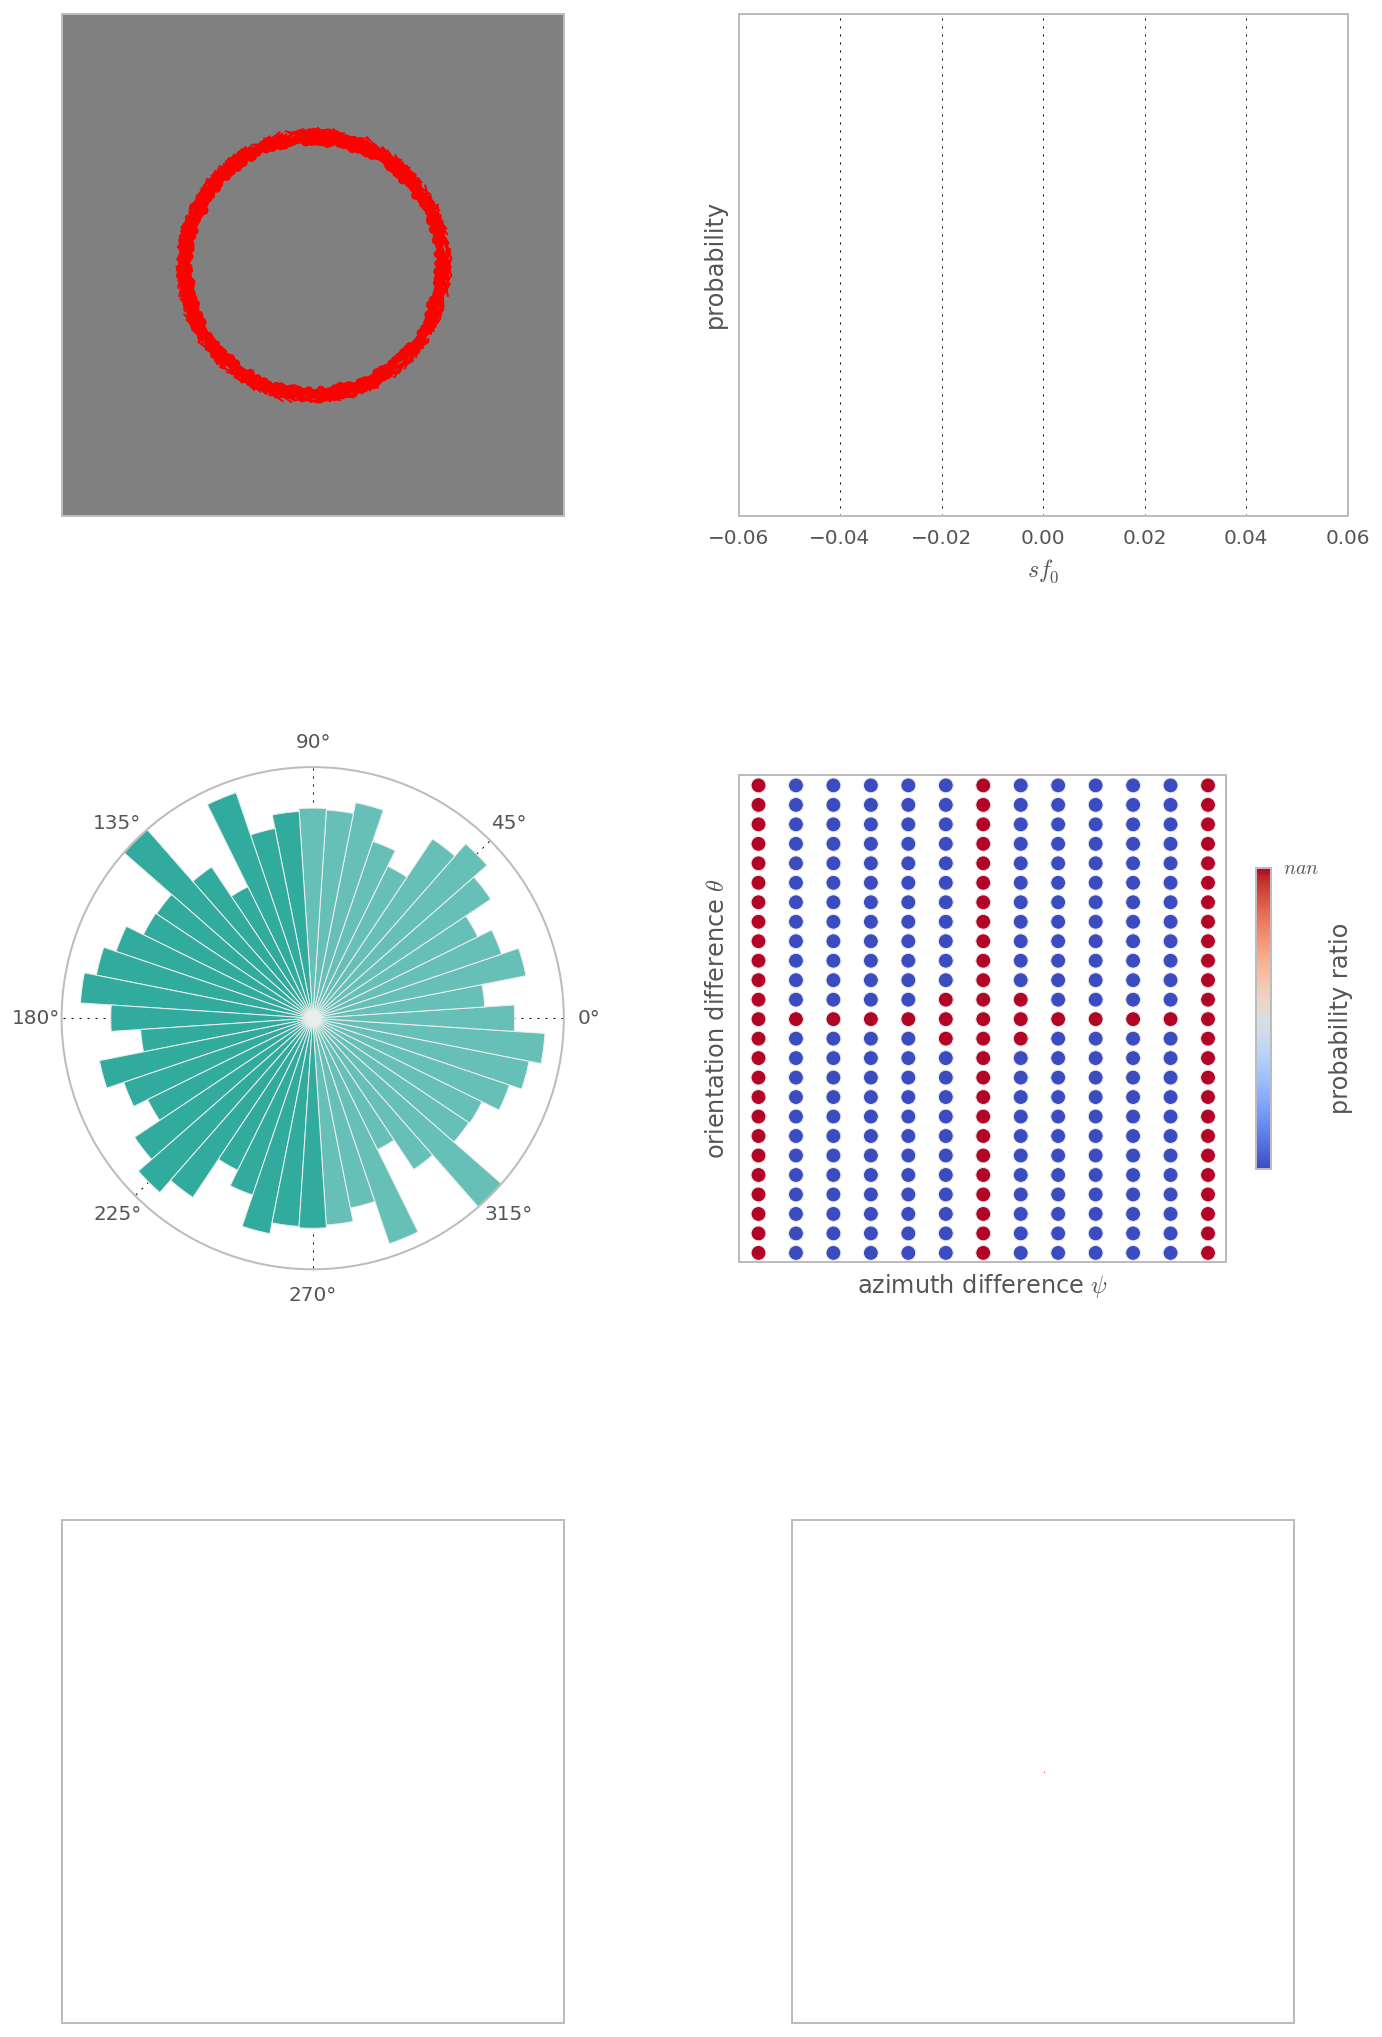

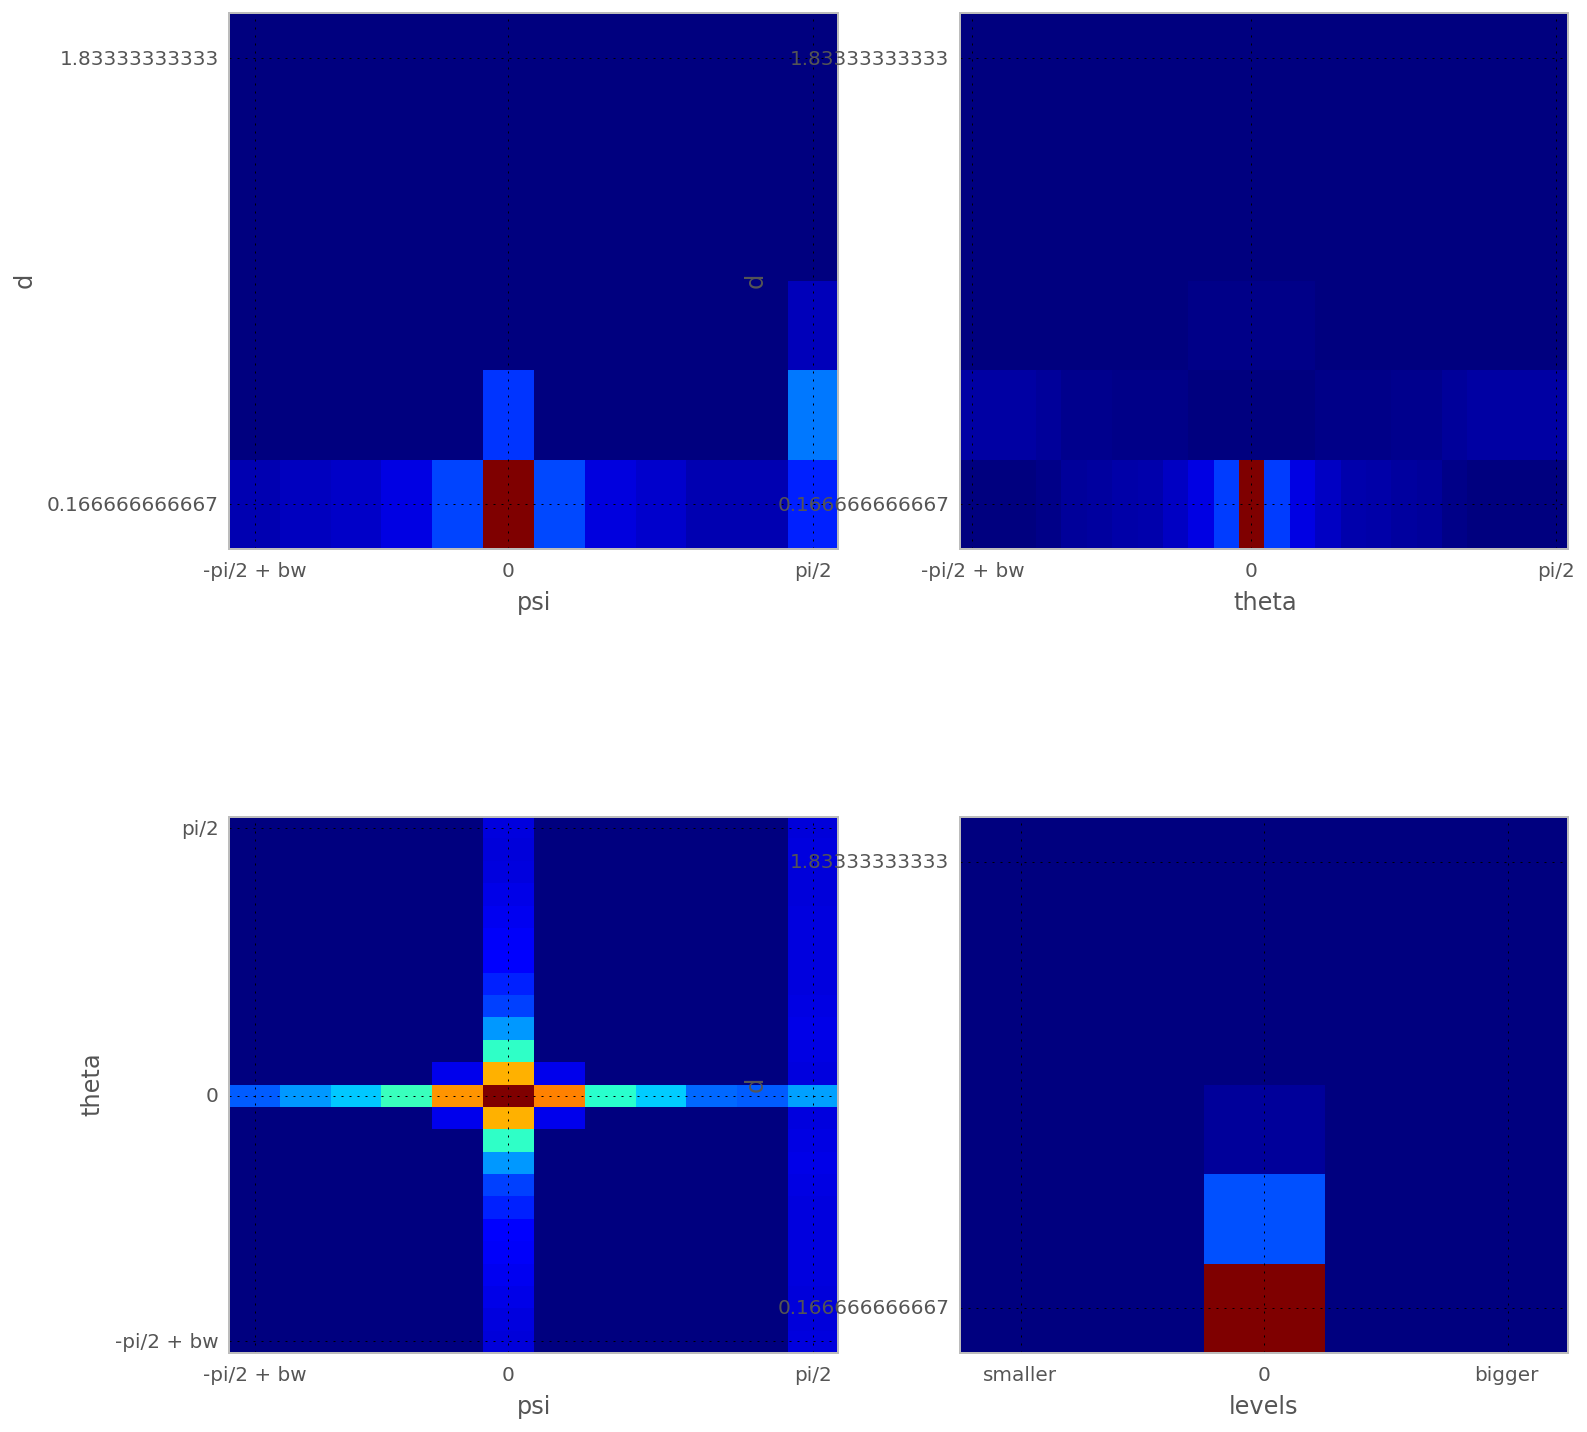

In [47]:
#! cocircular edges:
edgeslist = np.zeros((6, mp.pe.N, mp.pe.N_image))
#for i_N, angle in enumerate(np.linspace(0, 2*np.pi, N)):
for i_N, angle in enumerate(2*np.pi*np.random.rand(mp.pe.N)):
    edgeslist[0, i_N, :] = mp.N_X/2. - mp.N_X/4.*np.sin(angle) + .5 * np.random.randn(mp.pe.N_image)
    edgeslist[1, i_N, :] = mp.N_X/2. + mp.N_X/4.*np.cos(angle) + .5 * np.random.randn(mp.pe.N_image)
    edgeslist[2, i_N, :] = (np.pi/2 + angle + .5*np.pi/180 * np.random.randn(mp.pe.N_image)) % np.pi
    edgeslist[3, i_N, :] = 0.03
    edgeslist[4, i_N, :] = 1.
_ = myplot(edgeslist, mp=mp)#

#### cocircular edges on a wider radius

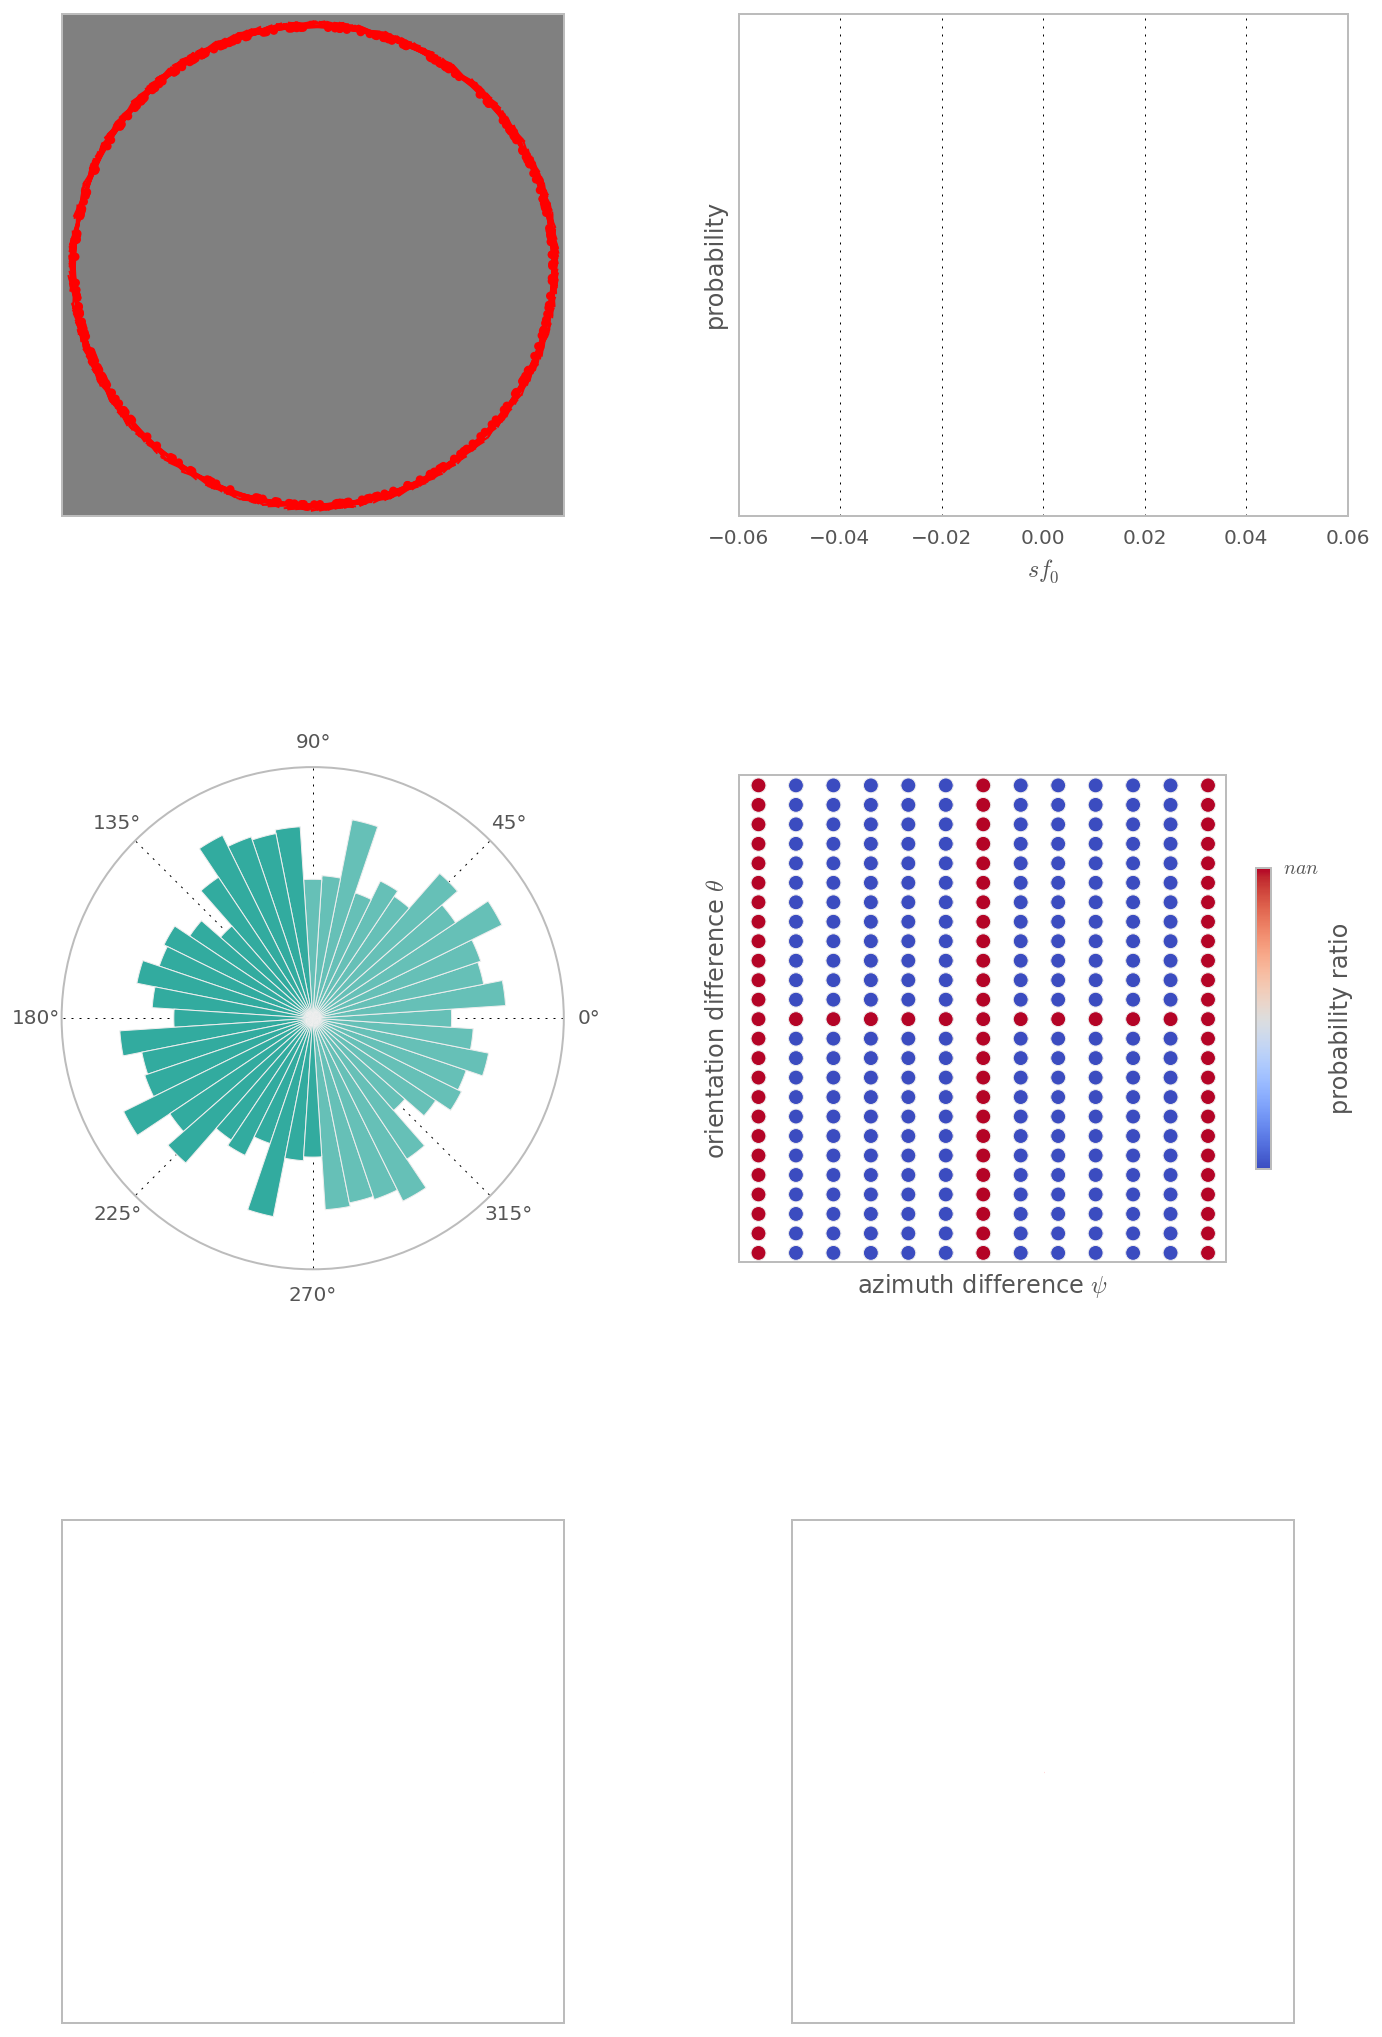

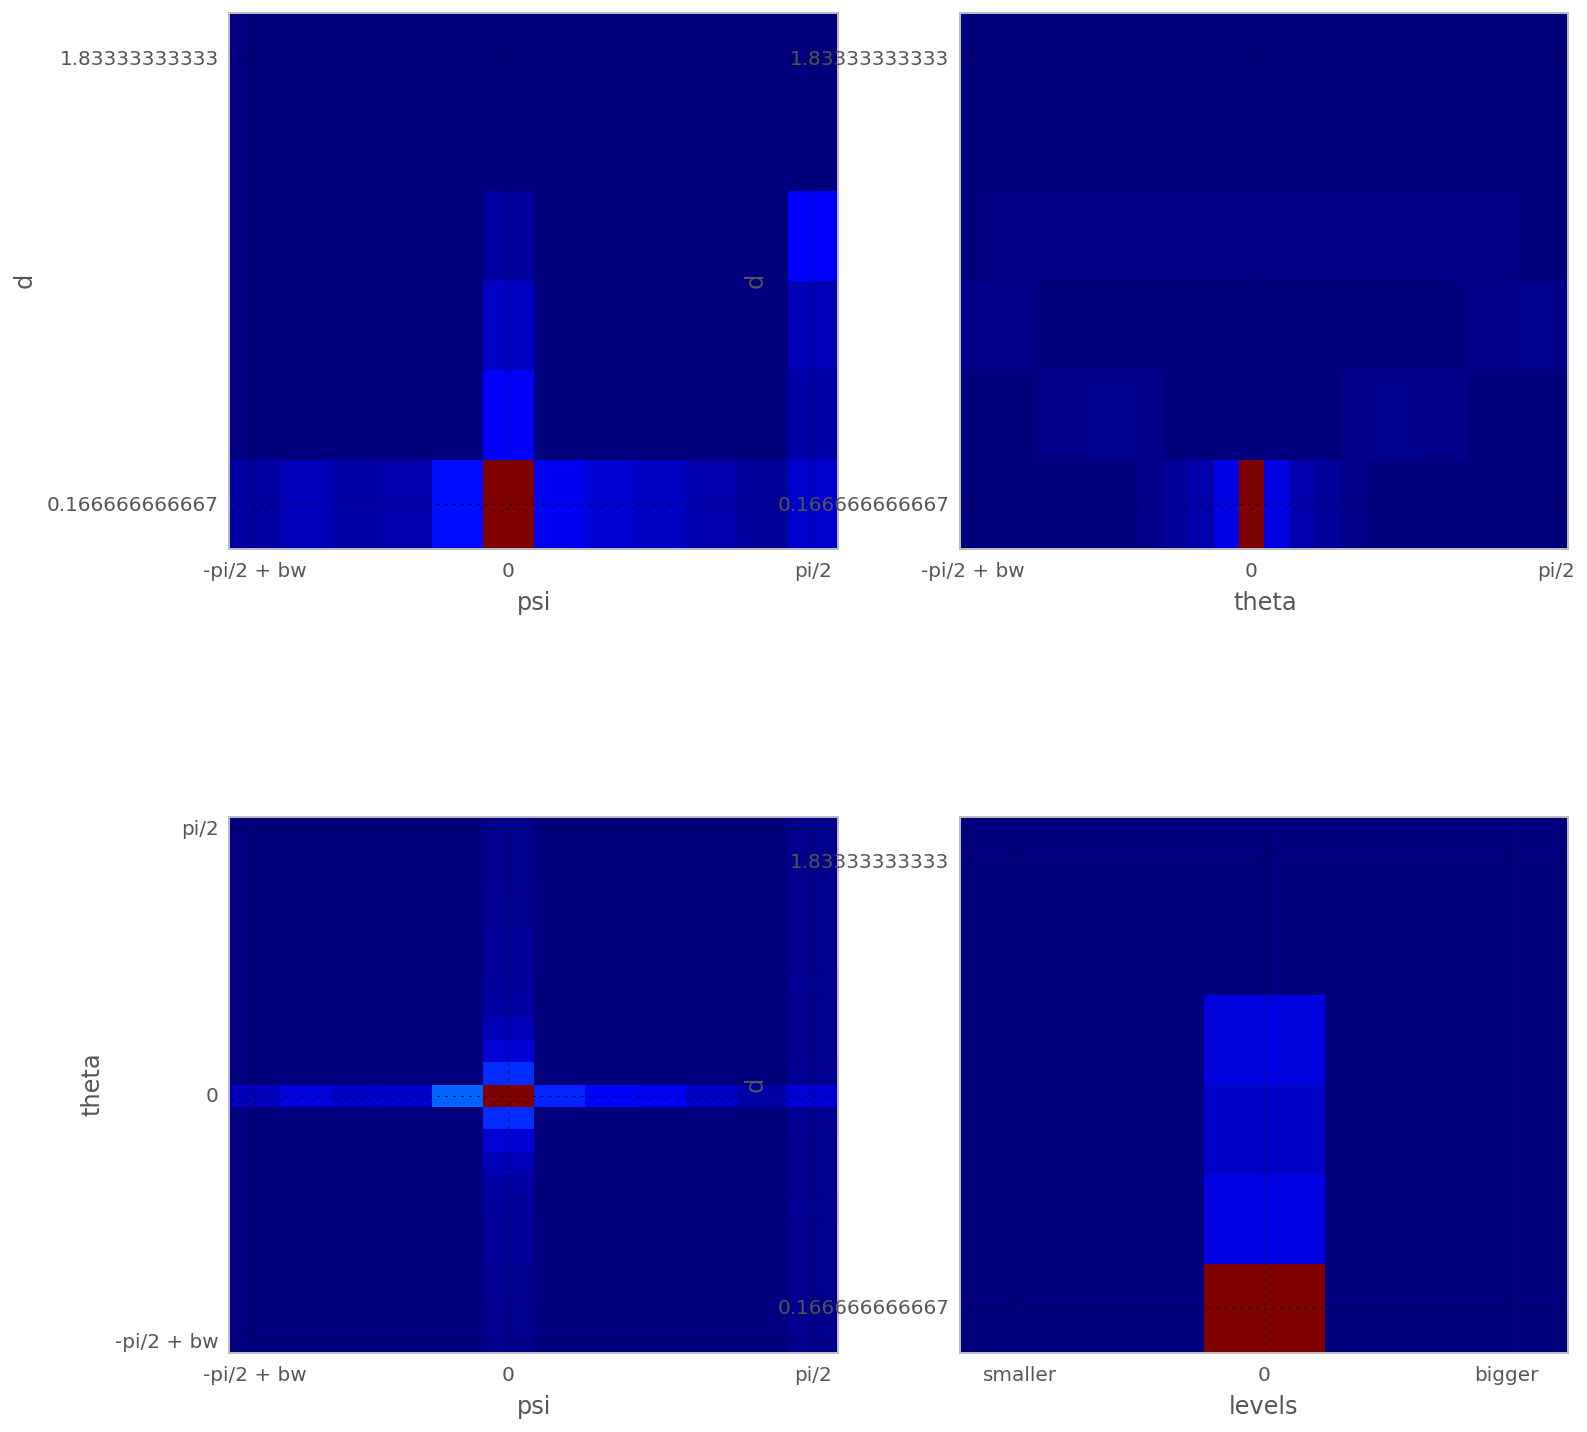

In [48]:
edgeslist = np.zeros((6, mp.pe.N, mp.pe.N_image))
#for i_N, angle in enumerate(np.linspace(0, 2*np.pi, pe.N)):
for i_N, angle in enumerate(2*np.pi*np.random.rand(mp.pe.N)):
    edgeslist[0, i_N, :] = mp.N_X/2. - .95*mp.N_X/2.*np.sin(angle) + .05 * np.random.randn(mp.pe.N_image)
    edgeslist[1, i_N, :] = mp.N_X/2. + .95*mp.N_X/2.*np.cos(angle) + .05 * np.random.randn(mp.pe.N_image)
    edgeslist[2, i_N, :] = (np.pi/2 + angle + .5*np.pi/180 * np.random.randn(mp.pe.N_image)) % np.pi
    edgeslist[3, i_N, :] = 0.03
    edgeslist[4, i_N, :] = 1.
_ = myplot(edgeslist, mp=mp)

### real-life examples

In [49]:
mp = SparseEdges('default_param.py')
print mp.run_mp.__doc__


        runs the MatchingPursuit algorithm on image

        


## some book keeping for the notebook

In [50]:
%install_ext https://raw.githubusercontent.com/rasbt/python_reference/master/ipython_magic/watermark.py
%load_ext watermark
%watermark

Installed watermark.py. To use it, type:
  %load_ext watermark
24/06/2015 15:00:34

CPython 2.7.9
IPython 3.1.0

compiler   : GCC 4.2.1 Compatible Apple LLVM 6.1.0 (clang-602.0.53)
system     : Darwin
release    : 14.3.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit


In [51]:
%install_ext http://raw.github.com/jrjohansson/version_information/master/version_information.py
%load_ext version_information
%version_information numpy, scipy, matplotlib, sympy

Installed version_information.py. To use it, type:
  %load_ext version_information


Software versions
Python 2.7.9 64bit [GCC 4.2.1 Compatible Apple LLVM 6.1.0 (clang-602.0.53)]
IPython 3.1.0
OS Darwin 14.3.0 x86_64 i386 64bit
numpy 1.9.2
scipy 0.15.1
matplotlib 1.4.3
sympy 0.7.6
Wed Jun 24 15:00:36 2015 CEST